![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/salem/anaconda3/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


/home/salem/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:280: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_upload.py:45: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  metadata = List(Dict, help='List of file metadata').tag(sync=True)


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [4]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [5]:
epidemic_duration_in_days = 365

Tamanho da população.

In [6]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [7]:
initially_infected = 52

Onde está a pasta base que contém os dados?

In [8]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos?

In [9]:
data_column_to_fit =  'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_FROM_SRAG'  #'total_cases_ESTIMATED'

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [10]:
target_location = 'Brazil'
#target_location = 'São Paulo-SP-Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [11]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [12]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [13]:
results_suffix = ''

Desejamos executar uma análise de sensibilidade também?

In [14]:
run_sensitivity_analysis = True

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [15]:
# custom papermill parameters

In [16]:
# Parameters
target_location = "MT-Brazil"
infer_parameters_from_data = True
results_suffix = ".mt-brazil"
run_sensitivity_analysis = False


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [17]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']])
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infecciosos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    peak_date = df_simulated_data["I"].idxmax().date()
    
    if zoom_on is None:    
        zoom_on = peak_date - pd.DateOffset(days=20)
        
    zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
    ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
    plt.figure()
    
    df_I_delta = df_simulated_data[['I_delta']]
    df_I_delta = df_I_delta[df_I_delta > 0]
    ax = sns.lineplot(data=df_I_delta)
    ax.set_title('Infecciosos novos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('I_delta'), format='png')
    plt.figure()
    

In [18]:
def plot_curve_fitting(df_simulation_data, df_data_target, target_location, best, comparison_date=None, file_name=None):
    peak_date = df_data_target["total_cases"].idxmax().date()
    if comparison_date is None:
        comparison_date = peak_date - pd.DateOffset(days=1)
        
    df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
    
    ax = sns.lineplot(data=df_simulation_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_2', 
                                                  'total_cases_ESTIMATED_FROM_SRAG']]\
                                           [comparison_date - pd.DateOffset(days=40):comparison_date], 
                 markers=True)

    ax.set_title(f'Simulação (E+I+R) frente aos dados históriocos. Linha vertical=estimativa de intervenção (se houver).')
    
    if 'duration_1' in best:
        intervention_date_1 = epidemic_start_date + pd.DateOffset(days=int(best['duration_1']))
        plt.axvline(intervention_date_1, color='red')

    if ('duration_1' in best) and ('duration_2' in best):
        intervention_date_2 = epidemic_start_date +  pd.DateOffset(days=int(best['duration_1'])) + pd.DateOffset(days=int(best['duration_2']))
        plt.axvline(intervention_date_2, color='red')

    if file_name is not None:
        ax.figure.savefig(results_folder + file_name + f'_{target_location.lower()}' + results_suffix + '.png', 
                          format='png')

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [19]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')

df_epidemy_data = df_epidemy_data.drop(['countriesAndTerritories', 'continent', 'population_year'], axis=1)

df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
0,2019-12-31,Afghanistan,0,0,0,0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,38928341.0


Vamos agora incorporar dados de municípios e estados brasileiros a partir da base disponibilizada pelo [Brasil.io](https://brasil.io/dataset/covid19/caso_full/). Para tanto, faremos algumas transformações para deixar o *layout* de ambas iguais e assim o *dataframe* poder ser usado de modo uniforme em seguida. Note que, para cidades e estados brasileiros, a localização terá a seguinte forma:
  - `CIDADE-ESTADO-Brazil`, para cidades.
  - `ESTADO-Brazil`, para estados.

In [20]:
df_brazil_city_data = pd.read_csv(f'{data_folder}brasil.io/dataset/covid19/caso_full.csv', parse_dates=['date'])
#print(df_brazil_city_data.tail())

def aux_build_location(row):
    if not pd.isnull(row['city']):
        prefix = f"{row['city']}-"
    else:
        prefix = ""
    
    return prefix + f"{row['state']}-Brazil"

df_brazil_city_data['location'] = df_brazil_city_data.apply(aux_build_location, axis=1)

df_brazil_city_data = df_brazil_city_data.rename(columns={"last_available_confirmed": "total_cases", "new_confirmed": "new_cases", "last_available_deaths": "total_deaths", "estimated_population_2019": "population"})
df_brazil_city_data = df_brazil_city_data[['date', 'location', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'population']]
df_brazil_city_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
51552,2020-02-27,SP-Brazil,0,0,1,0,45919049.0
51553,2020-02-26,São Paulo-SP-Brazil,0,0,1,0,12252023.0
51554,2020-02-26,SP-Brazil,0,0,1,0,45919049.0
51555,2020-02-25,São Paulo-SP-Brazil,1,0,1,0,12252023.0
51556,2020-02-25,SP-Brazil,1,0,1,0,45919049.0


In [21]:
df_epidemy_data = df_epidemy_data.append(df_brazil_city_data).sort_values(by=['date'])
df_epidemy_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
941,2020-05-04,Lucas do Rio Verde-MT-Brazil,0,0,7,1,65534.0
942,2020-05-04,Mirassol d'Oeste-MT-Brazil,0,0,8,1,27739.0
943,2020-05-04,Nova Monte Verde-MT-Brazil,0,0,1,0,9178.0
925,2020-05-04,Alta Floresta-MT-Brazil,0,0,2,0,51782.0
292,2020-05-04,Acaraú-CE-Brazil,0,0,31,1,62641.0


Selecionemos apenas dados sobre o país de interesse.

In [22]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

In [23]:
df_srag_adjustment_multipliers = pd.read_csv(f'{results_folder}srag_adjustment_multipliers.brazil.csv', parse_dates=['date'], index_col=0)
df_srag_adjustment_multipliers.tail()

,SRAG_adjustment_multiplier
date,
2020-04-07,3.595084
2020-04-08,3.595084
2020-04-09,3.595084
2020-04-10,3.595084
2020-04-11,3.595084


Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,10,0,302,11,3484466.0,NaN,4530,NaN
2020-05-01,18,0,320,11,3484466.0,NaN,4800,NaN
2020-05-02,13,1,333,12,3484466.0,NaN,4995,NaN
2020-05-03,4,0,337,12,3484466.0,NaN,5055,NaN
2020-05-04,0,0,337,12,3484466.0,NaN,5055,NaN


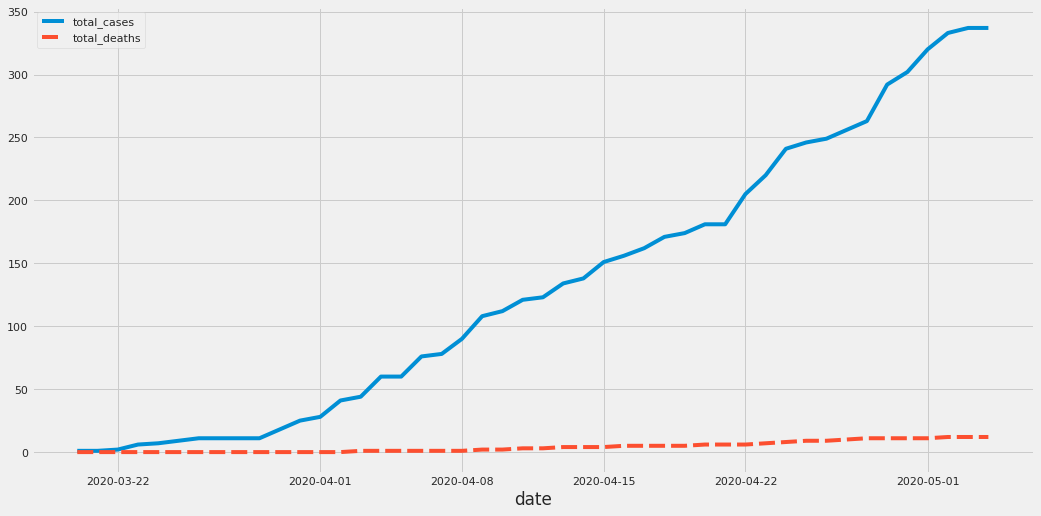

In [24]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 15 * df_data_target['total_cases']

# we have data for SRAG in Brazil only 
if target_location == 'Brazil':
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = \
        (df_data_target['new_cases'] * df_srag_adjustment_multipliers['SRAG_adjustment_multiplier'].reindex_like(df_data_target, method='ffill'))\
            .cumsum()
else:
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = df_data_target['new_cases'] * np.nan

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

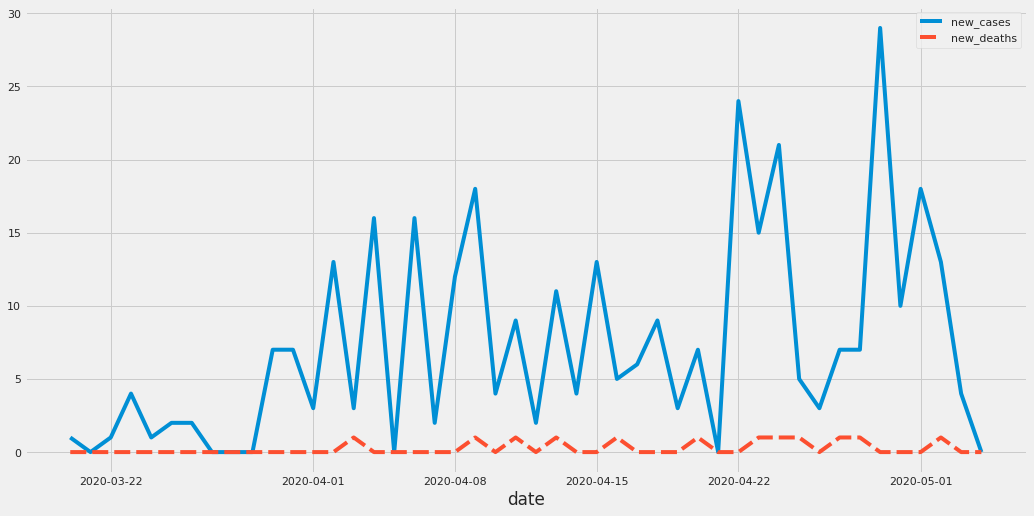

In [25]:
sns.lineplot(data=df_data_target[['new_cases', 'new_deaths']])

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [26]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-04-04 00:00:00')

In [27]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row[data_column_to_fit] #['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-04-04 00:00:00, population_size=3484466.0, initially_infected=900.0


Filtremos os dados a partir da data de interesse.

In [28]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [29]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [30]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [31]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [32]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [33]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [34]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [35]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [36]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [37]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [38]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [39]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [40]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-04,3.483566e+06,900.000000,0.000000,0.000000,0.000000,0.00000,0.00000,900.000000,900.000000
2020-04-05,3.483566e+06,90.000000,0.000000,810.000000,810.000000,0.00000,0.00000,900.000000,900.000000
2020-04-06,3.482918e+06,656.832629,647.832629,648.000000,81.000000,243.00000,243.00000,1304.832629,1547.832629
2020-04-07,3.482400e+06,583.852985,518.169722,1044.749366,591.149366,437.40000,194.40000,1628.602350,2066.002350
2020-04-08,3.481565e+06,893.689231,835.303932,1256.792242,525.467686,750.82481,313.42481,2150.481473,2901.306283


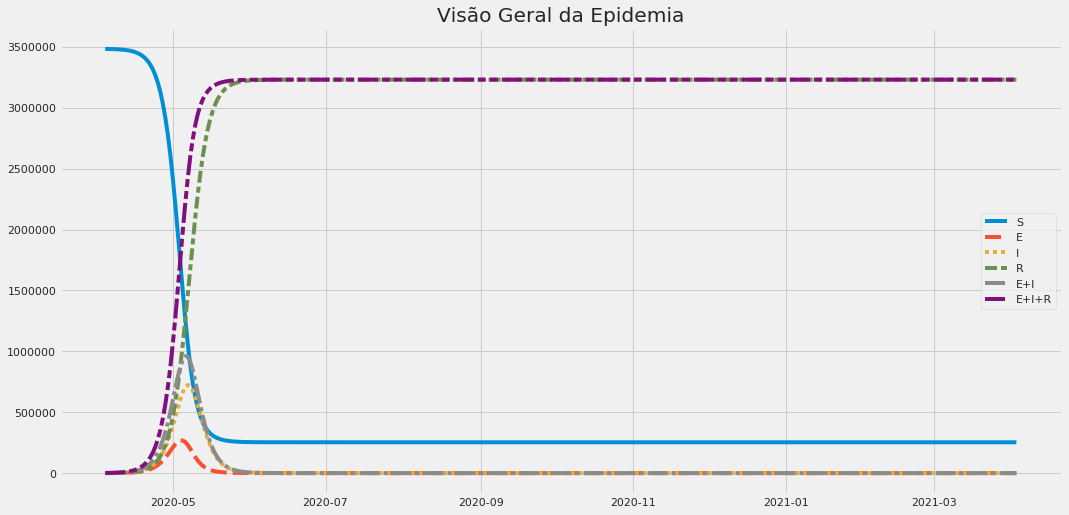

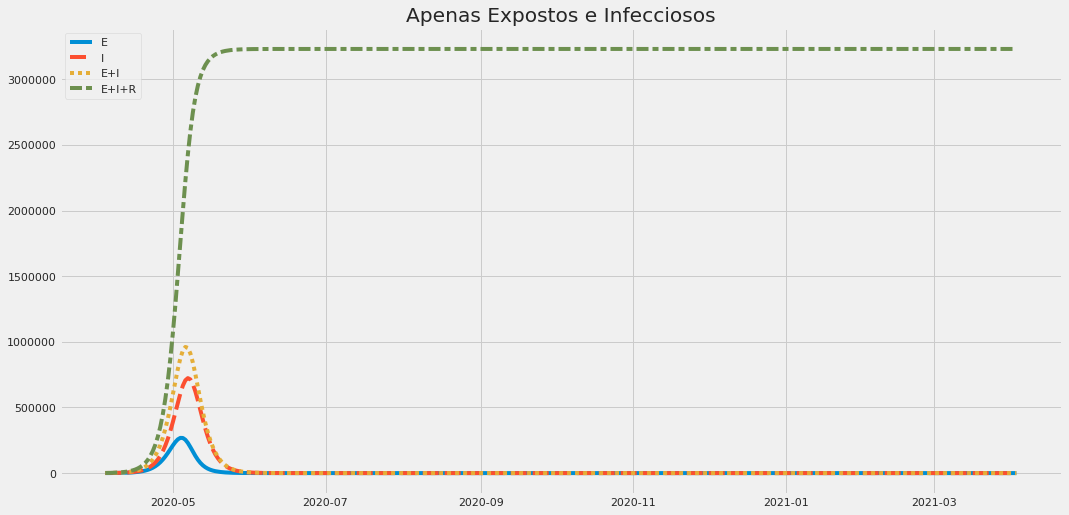

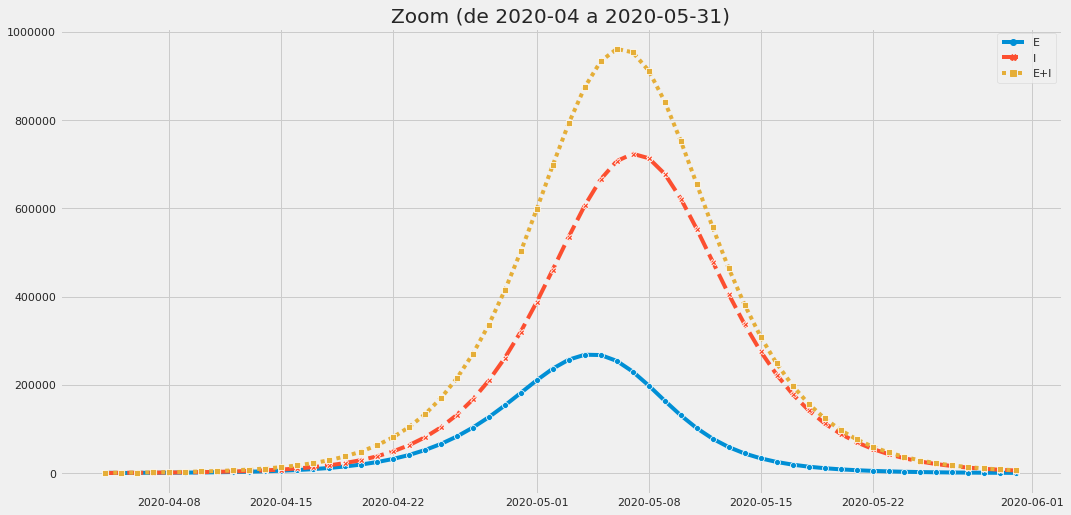

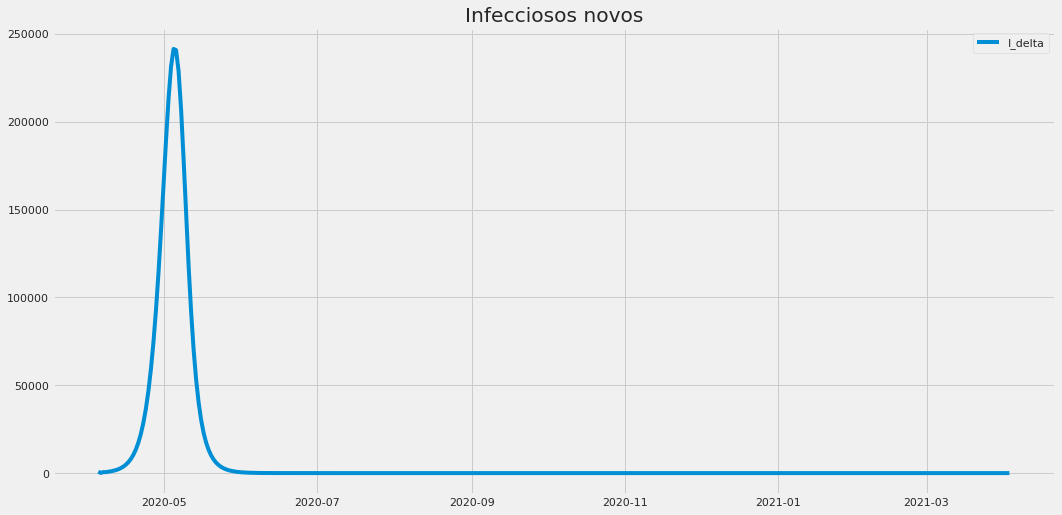

<Figure size 1152x576 with 0 Axes>

In [41]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

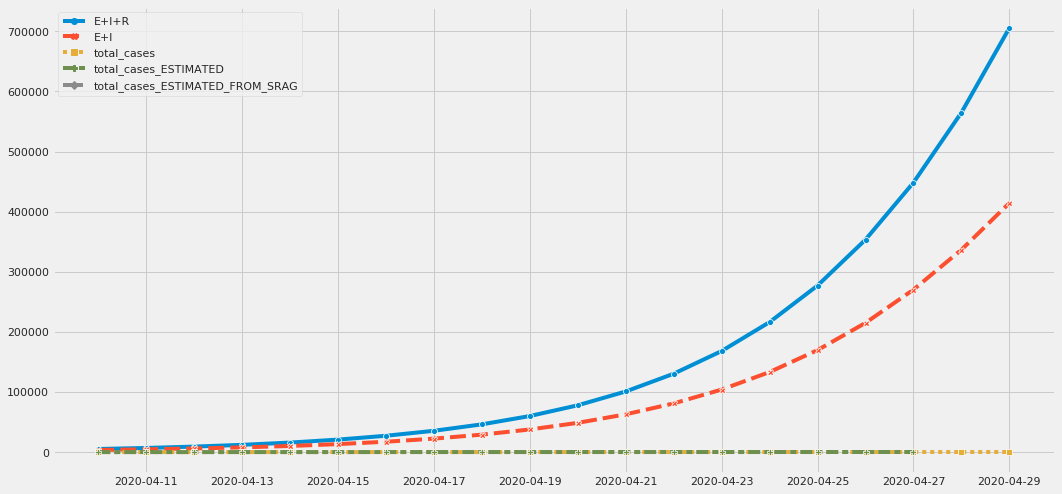

In [42]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_FROM_SRAG']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [43]:
alpha = 1.0

beta = dynamic_parameter([(0.9, 10), 
                          (0.8, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

gamma = 0.4

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-04,3.483566e+06,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,900.000000,900.000000
2020-04-05,3.483566e+06,0.000000,0.000000,900.000000,900.000000,0.000000,0.000000,900.000000,900.000000
2020-04-06,3.482756e+06,809.790786,809.790786,540.000000,0.000000,360.000000,360.000000,1349.790786,1709.790786
2020-04-07,3.482270e+06,485.761525,485.761525,1133.790786,809.790786,576.000000,216.000000,1619.552311,2195.552311
2020-04-08,3.481251e+06,1019.768749,1019.768749,1166.035996,485.761525,1029.516314,453.516314,2185.804745,3215.321059


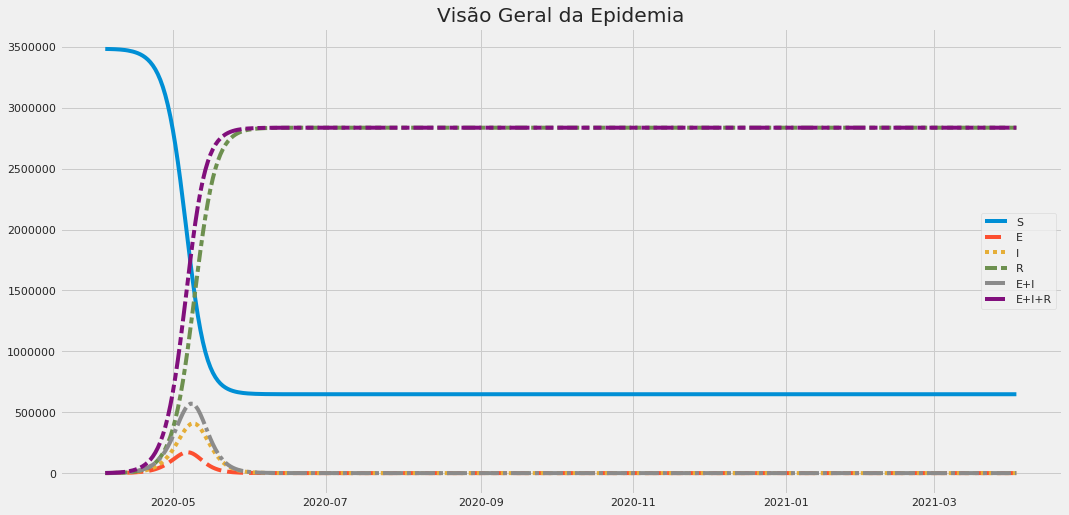

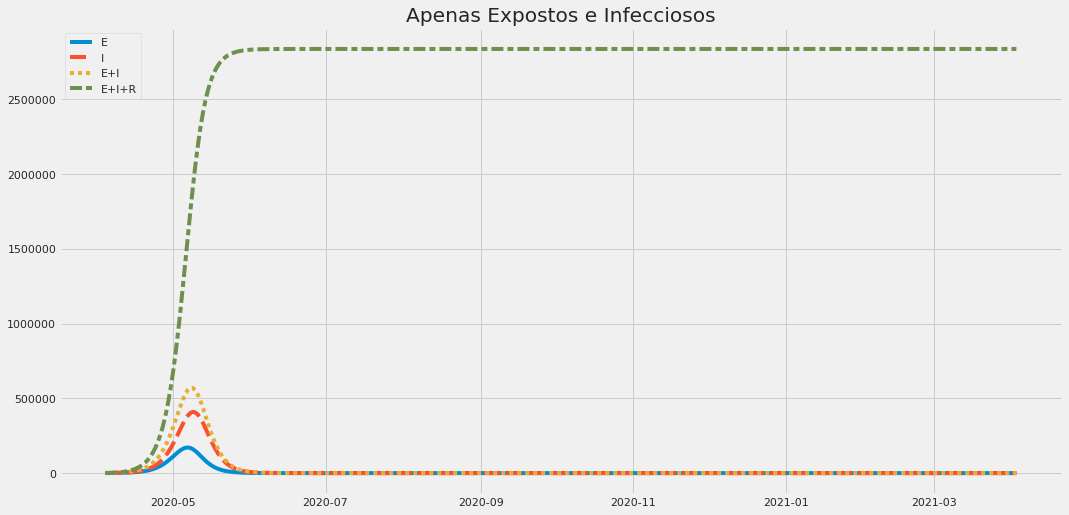

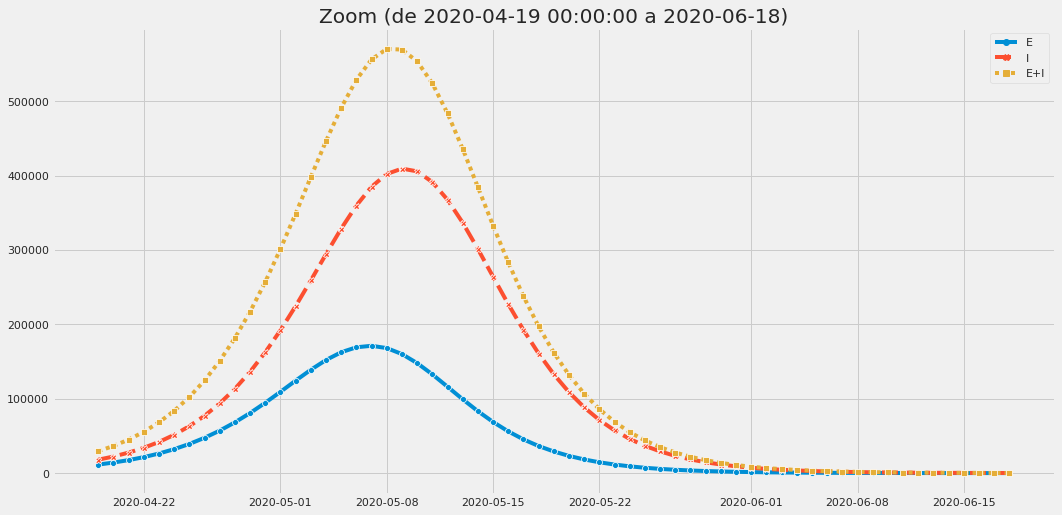

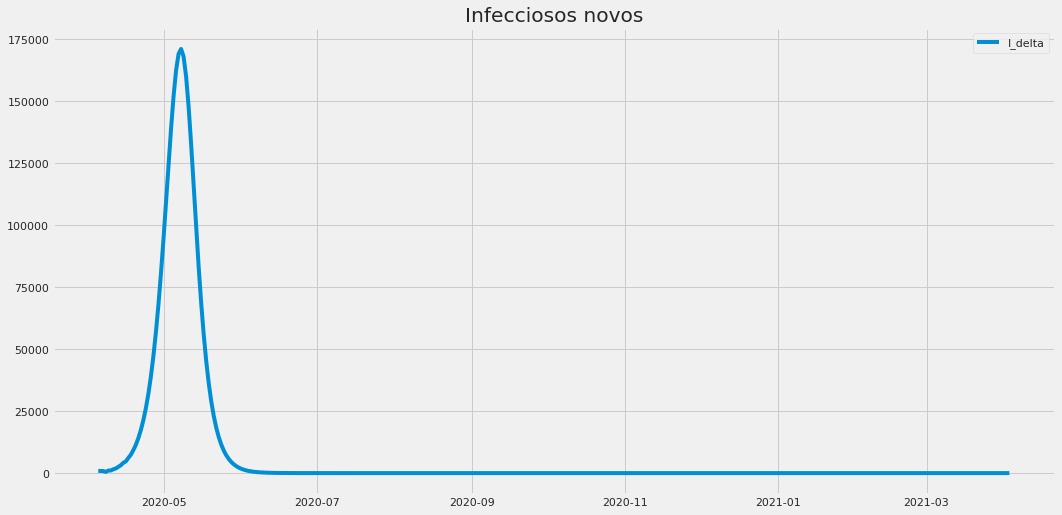

<Figure size 1152x576 with 0 Axes>

In [44]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

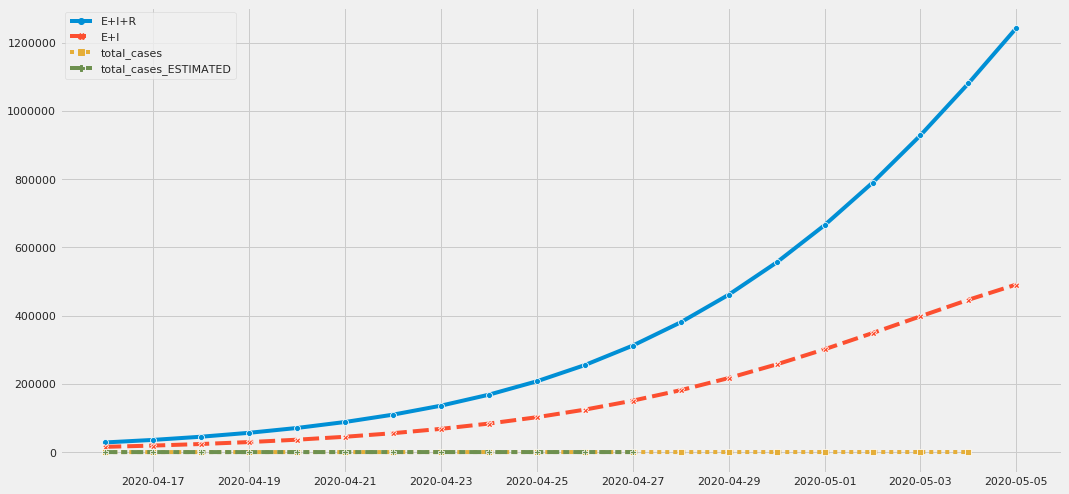

In [45]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [46]:
def objective_for_simulation(args):
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        prev_alpha = None
        prev_beta = None
        prev_gamma = None
        prev_duration = None
        for params in params_sets:
            cur_alpha = params.get('alpha', prev_alpha)
            cur_beta = params.get('beta', prev_beta)
            cur_gamma = params.get('gamma', prev_gamma)
            cur_duration = int(params.get('duration', prev_duration))
            
            alpha.append((cur_alpha, cur_duration))
            beta.append((cur_beta, cur_duration))
            gamma.append((cur_gamma, cur_duration))
            
            prev_alpha = cur_alpha
            prev_beta = cur_beta
            prev_gamma = cur_gamma
            prev_duration = cur_duration
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    df_diff_cases = df_data_target[data_column_to_fit] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [47]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, 15)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

  1%|          | 11/1000 [00:00<00:09, 108.20trial/s, best loss: 105.13925189230353]

  2%|▏         | 22/1000 [00:00<00:09, 108.59trial/s, best loss: 105.13925189230353]

  3%|▎         | 29/1000 [00:00<00:10, 89.66trial/s, best loss: 105.13925189230353] 

  4%|▎         | 36/1000 [00:00<00:11, 80.57trial/s, best loss: 78.72922767809794] 

  4%|▍         | 44/1000 [00:00<00:12, 78.39trial/s, best loss: 78.72922767809794]

  5%|▌         | 52/1000 [00:00<00:12, 78.58trial/s, best loss: 78.72922767809794]

  6%|▌         | 60/1000 [00:00<00:12, 78.03trial/s, best loss: 78.72922767809794]

  7%|▋         | 69/1000 [00:00<00:11, 79.78trial/s, best loss: 50.532490416930386]

  8%|▊         | 78/1000 [00:00<00:11, 81.89trial/s, best loss: 50.532490416930386]

  9%|▊         | 87/1000 [00:01<00:11, 82.35trial/s, best loss: 50.532490416930386]

 10%|▉         | 96/1000 [00:01<00:10, 82.66trial/s, best loss: 50.532490416930386]

 10%|█         | 105/1000 [00:01<00:11, 80.02trial/s, best loss: 50.532490416930386]

 11%|█▏        | 113/1000 [00:01<00:11, 79.56trial/s, best loss: 50.532490416930386]

 12%|█▏        | 121/1000 [00:01<00:11, 79.21trial/s, best loss: 50.532490416930386]

 13%|█▎        | 129/1000 [00:01<00:11, 78.37trial/s, best loss: 50.532490416930386]

 14%|█▎        | 137/1000 [00:01<00:11, 77.81trial/s, best loss: 50.532490416930386]

 14%|█▍        | 145/1000 [00:01<00:10, 78.10trial/s, best loss: 50.532490416930386]

 15%|█▌        | 153/1000 [00:01<00:10, 78.48trial/s, best loss: 50.532490416930386]

 16%|█▌        | 161/1000 [00:01<00:10, 78.56trial/s, best loss: 50.532490416930386]

 17%|█▋        | 169/1000 [00:02<00:11, 70.20trial/s, best loss: 50.532490416930386]

 18%|█▊        | 177/1000 [00:02<00:12, 66.65trial/s, best loss: 50.532490416930386]

 18%|█▊        | 185/1000 [00:02<00:11, 68.43trial/s, best loss: 50.532490416930386]

 19%|█▉        | 192/1000 [00:02<00:11, 68.65trial/s, best loss: 50.532490416930386]

 20%|██        | 200/1000 [00:02<00:11, 70.33trial/s, best loss: 50.532490416930386]

 21%|██        | 208/1000 [00:02<00:11, 69.45trial/s, best loss: 50.532490416930386]

 22%|██▏       | 216/1000 [00:02<00:11, 70.92trial/s, best loss: 50.532490416930386]

 22%|██▏       | 224/1000 [00:02<00:10, 72.92trial/s, best loss: 50.532490416930386]

 23%|██▎       | 233/1000 [00:03<00:10, 74.61trial/s, best loss: 50.532490416930386]

 24%|██▍       | 241/1000 [00:03<00:10, 74.58trial/s, best loss: 50.532490416930386]

 25%|██▍       | 249/1000 [00:03<00:10, 72.26trial/s, best loss: 50.532490416930386]

 26%|██▌       | 257/1000 [00:03<00:10, 71.60trial/s, best loss: 50.532490416930386]

 26%|██▋       | 265/1000 [00:03<00:12, 61.23trial/s, best loss: 50.532490416930386]

 27%|██▋       | 272/1000 [00:03<00:11, 62.15trial/s, best loss: 50.532490416930386]

 28%|██▊       | 280/1000 [00:03<00:10, 66.13trial/s, best loss: 50.532490416930386]

 29%|██▉       | 288/1000 [00:03<00:10, 68.88trial/s, best loss: 50.532490416930386]

 30%|██▉       | 296/1000 [00:03<00:10, 66.38trial/s, best loss: 50.532490416930386]

 30%|███       | 303/1000 [00:04<00:10, 67.33trial/s, best loss: 50.532490416930386]

 31%|███       | 311/1000 [00:04<00:09, 69.15trial/s, best loss: 33.8994404268622]  

 32%|███▏      | 318/1000 [00:04<00:10, 67.81trial/s, best loss: 33.8994404268622]

 33%|███▎      | 326/1000 [00:04<00:09, 68.66trial/s, best loss: 33.8994404268622]

 33%|███▎      | 333/1000 [00:04<00:09, 68.80trial/s, best loss: 33.8994404268622]

 34%|███▍      | 340/1000 [00:04<00:09, 67.07trial/s, best loss: 33.8994404268622]

 35%|███▍      | 347/1000 [00:04<00:10, 64.66trial/s, best loss: 33.8994404268622]

 35%|███▌      | 354/1000 [00:04<00:10, 62.31trial/s, best loss: 33.8994404268622]

 36%|███▌      | 361/1000 [00:05<00:10, 59.54trial/s, best loss: 33.8994404268622]

 37%|███▋      | 368/1000 [00:05<00:10, 59.37trial/s, best loss: 33.8994404268622]

 38%|███▊      | 375/1000 [00:05<00:10, 61.27trial/s, best loss: 33.8994404268622]

 38%|███▊      | 382/1000 [00:05<00:11, 52.49trial/s, best loss: 33.8994404268622]

 39%|███▉      | 388/1000 [00:05<00:11, 53.51trial/s, best loss: 33.8994404268622]

 39%|███▉      | 394/1000 [00:05<00:12, 49.78trial/s, best loss: 33.8994404268622]

 40%|████      | 400/1000 [00:05<00:11, 51.00trial/s, best loss: 33.8994404268622]

 41%|████      | 406/1000 [00:05<00:11, 52.53trial/s, best loss: 33.8994404268622]

 41%|████▏     | 413/1000 [00:05<00:10, 54.84trial/s, best loss: 33.8994404268622]

 42%|████▏     | 419/1000 [00:06<00:10, 52.98trial/s, best loss: 33.8994404268622]

 42%|████▎     | 425/1000 [00:06<00:10, 54.05trial/s, best loss: 33.8994404268622]

 43%|████▎     | 431/1000 [00:06<00:10, 53.69trial/s, best loss: 33.8994404268622]

 44%|████▎     | 437/1000 [00:06<00:10, 55.08trial/s, best loss: 33.8994404268622]

 44%|████▍     | 444/1000 [00:06<00:09, 56.73trial/s, best loss: 33.8994404268622]

 45%|████▌     | 451/1000 [00:06<00:09, 57.95trial/s, best loss: 33.8994404268622]

 46%|████▌     | 457/1000 [00:06<00:09, 58.49trial/s, best loss: 33.8994404268622]

 46%|████▋     | 464/1000 [00:06<00:09, 59.41trial/s, best loss: 33.8994404268622]

 47%|████▋     | 471/1000 [00:06<00:08, 59.22trial/s, best loss: 33.8994404268622]

 48%|████▊     | 477/1000 [00:07<00:09, 57.67trial/s, best loss: 33.8994404268622]

 48%|████▊     | 484/1000 [00:07<00:08, 58.53trial/s, best loss: 33.8994404268622]

 49%|████▉     | 490/1000 [00:07<00:09, 55.30trial/s, best loss: 33.8994404268622]

 50%|████▉     | 497/1000 [00:07<00:08, 57.34trial/s, best loss: 33.8994404268622]

 50%|█████     | 504/1000 [00:07<00:08, 58.73trial/s, best loss: 33.8994404268622]

 51%|█████     | 511/1000 [00:07<00:08, 60.03trial/s, best loss: 33.8994404268622]

 52%|█████▏    | 518/1000 [00:07<00:07, 60.91trial/s, best loss: 33.8994404268622]

 52%|█████▎    | 525/1000 [00:07<00:07, 61.62trial/s, best loss: 33.8994404268622]

 53%|█████▎    | 532/1000 [00:08<00:07, 62.11trial/s, best loss: 33.8994404268622]

 54%|█████▍    | 539/1000 [00:08<00:08, 56.21trial/s, best loss: 33.8994404268622]

 55%|█████▍    | 545/1000 [00:08<00:08, 54.71trial/s, best loss: 33.8994404268622]

 55%|█████▌    | 552/1000 [00:08<00:07, 56.40trial/s, best loss: 33.8994404268622]

 56%|█████▌    | 558/1000 [00:08<00:07, 56.21trial/s, best loss: 33.8994404268622]

 56%|█████▋    | 564/1000 [00:08<00:07, 56.76trial/s, best loss: 33.8994404268622]

 57%|█████▋    | 570/1000 [00:08<00:07, 57.36trial/s, best loss: 33.8994404268622]

 58%|█████▊    | 576/1000 [00:08<00:07, 57.83trial/s, best loss: 33.8994404268622]

 58%|█████▊    | 582/1000 [00:08<00:07, 58.46trial/s, best loss: 33.8994404268622]

 59%|█████▉    | 589/1000 [00:09<00:06, 58.89trial/s, best loss: 33.8994404268622]

 60%|█████▉    | 595/1000 [00:09<00:07, 56.27trial/s, best loss: 33.8994404268622]

 60%|██████    | 601/1000 [00:09<00:07, 55.32trial/s, best loss: 33.8994404268622]

 61%|██████    | 607/1000 [00:09<00:07, 56.00trial/s, best loss: 33.8994404268622]

 61%|██████▏   | 613/1000 [00:09<00:06, 56.62trial/s, best loss: 33.8994404268622]

 62%|██████▏   | 619/1000 [00:09<00:06, 56.81trial/s, best loss: 33.8994404268622]

 62%|██████▎   | 625/1000 [00:09<00:06, 57.27trial/s, best loss: 33.8994404268622]

 63%|██████▎   | 631/1000 [00:09<00:06, 57.40trial/s, best loss: 33.8994404268622]

 64%|██████▎   | 637/1000 [00:09<00:06, 57.60trial/s, best loss: 33.8994404268622]

 64%|██████▍   | 643/1000 [00:09<00:06, 57.92trial/s, best loss: 33.8994404268622]

 65%|██████▍   | 649/1000 [00:10<00:06, 56.77trial/s, best loss: 33.8994404268622]

 66%|██████▌   | 655/1000 [00:10<00:06, 52.10trial/s, best loss: 33.8994404268622]

 66%|██████▌   | 661/1000 [00:10<00:06, 52.63trial/s, best loss: 33.8994404268622]

 67%|██████▋   | 667/1000 [00:10<00:06, 53.98trial/s, best loss: 33.8994404268622]

 67%|██████▋   | 673/1000 [00:10<00:06, 50.48trial/s, best loss: 33.8994404268622]

 68%|██████▊   | 679/1000 [00:10<00:06, 51.70trial/s, best loss: 33.8994404268622]

 68%|██████▊   | 685/1000 [00:10<00:05, 52.58trial/s, best loss: 33.8994404268622]

 69%|██████▉   | 691/1000 [00:10<00:05, 52.61trial/s, best loss: 33.8994404268622]

 70%|██████▉   | 697/1000 [00:11<00:05, 52.37trial/s, best loss: 33.8994404268622]

 70%|███████   | 703/1000 [00:11<00:05, 50.87trial/s, best loss: 33.8994404268622]

 71%|███████   | 709/1000 [00:11<00:05, 50.71trial/s, best loss: 33.8994404268622]

 72%|███████▏  | 715/1000 [00:11<00:06, 46.57trial/s, best loss: 33.8994404268622]

 72%|███████▏  | 721/1000 [00:11<00:05, 48.23trial/s, best loss: 33.8994404268622]

 73%|███████▎  | 727/1000 [00:11<00:05, 50.18trial/s, best loss: 33.8994404268622]

 73%|███████▎  | 733/1000 [00:11<00:05, 51.92trial/s, best loss: 33.8994404268622]

 74%|███████▍  | 739/1000 [00:11<00:04, 53.02trial/s, best loss: 33.8994404268622]

 74%|███████▍  | 745/1000 [00:11<00:04, 53.62trial/s, best loss: 33.8994404268622]

 75%|███████▌  | 751/1000 [00:12<00:04, 53.35trial/s, best loss: 33.8994404268622]

 76%|███████▌  | 757/1000 [00:12<00:04, 53.60trial/s, best loss: 33.8994404268622]

 76%|███████▋  | 763/1000 [00:12<00:04, 51.67trial/s, best loss: 33.8994404268622]

 77%|███████▋  | 769/1000 [00:12<00:04, 52.50trial/s, best loss: 33.8994404268622]

 78%|███████▊  | 775/1000 [00:12<00:04, 52.70trial/s, best loss: 33.8994404268622]

 78%|███████▊  | 781/1000 [00:12<00:04, 53.16trial/s, best loss: 33.8994404268622]

 79%|███████▊  | 787/1000 [00:12<00:03, 53.49trial/s, best loss: 33.8994404268622]

 79%|███████▉  | 793/1000 [00:12<00:03, 53.67trial/s, best loss: 33.8994404268622]

 80%|███████▉  | 799/1000 [00:12<00:03, 53.84trial/s, best loss: 33.8994404268622]

 80%|████████  | 805/1000 [00:13<00:03, 52.73trial/s, best loss: 33.8994404268622]

 81%|████████  | 811/1000 [00:13<00:03, 52.31trial/s, best loss: 33.8994404268622]

 82%|████████▏ | 817/1000 [00:13<00:03, 50.83trial/s, best loss: 33.8994404268622]

 82%|████████▏ | 823/1000 [00:13<00:03, 51.48trial/s, best loss: 33.83641092961545]

 83%|████████▎ | 829/1000 [00:13<00:03, 51.25trial/s, best loss: 33.83641092961545]

 84%|████████▎ | 835/1000 [00:13<00:03, 51.61trial/s, best loss: 33.83641092961545]

 84%|████████▍ | 841/1000 [00:13<00:03, 51.81trial/s, best loss: 33.83641092961545]

 85%|████████▍ | 847/1000 [00:13<00:02, 52.12trial/s, best loss: 33.83641092961545]

 85%|████████▌ | 853/1000 [00:14<00:02, 50.46trial/s, best loss: 33.83641092961545]

 86%|████████▌ | 859/1000 [00:14<00:02, 50.10trial/s, best loss: 33.83641092961545]

 86%|████████▋ | 865/1000 [00:14<00:02, 48.75trial/s, best loss: 33.83641092961545]

 87%|████████▋ | 871/1000 [00:14<00:02, 49.41trial/s, best loss: 33.83641092961545]

 88%|████████▊ | 876/1000 [00:14<00:02, 49.28trial/s, best loss: 33.83641092961545]

 88%|████████▊ | 881/1000 [00:14<00:02, 49.47trial/s, best loss: 33.83641092961545]

 89%|████████▊ | 887/1000 [00:14<00:02, 49.98trial/s, best loss: 33.83641092961545]

 89%|████████▉ | 893/1000 [00:14<00:02, 45.39trial/s, best loss: 33.83641092961545]

 90%|████████▉ | 899/1000 [00:15<00:02, 46.89trial/s, best loss: 33.83641092961545]

 90%|█████████ | 904/1000 [00:15<00:02, 46.89trial/s, best loss: 33.83641092961545]

 91%|█████████ | 909/1000 [00:15<00:01, 46.44trial/s, best loss: 33.83641092961545]

 91%|█████████▏| 914/1000 [00:15<00:01, 46.67trial/s, best loss: 33.83641092961545]

 92%|█████████▏| 920/1000 [00:15<00:01, 47.73trial/s, best loss: 33.83641092961545]

 92%|█████████▎| 925/1000 [00:15<00:01, 47.92trial/s, best loss: 33.83641092961545]

 93%|█████████▎| 930/1000 [00:15<00:01, 47.93trial/s, best loss: 33.83641092961545]

 94%|█████████▎| 935/1000 [00:15<00:01, 47.67trial/s, best loss: 33.83641092961545]

 94%|█████████▍| 940/1000 [00:15<00:01, 47.76trial/s, best loss: 33.83641092961545]

 94%|█████████▍| 945/1000 [00:15<00:01, 48.19trial/s, best loss: 33.83641092961545]

 95%|█████████▌| 950/1000 [00:16<00:01, 47.42trial/s, best loss: 33.83641092961545]

 96%|█████████▌| 955/1000 [00:16<00:00, 47.90trial/s, best loss: 33.83641092961545]

 96%|█████████▌| 960/1000 [00:16<00:00, 45.35trial/s, best loss: 33.83641092961545]

 96%|█████████▋| 965/1000 [00:16<00:00, 46.00trial/s, best loss: 33.83641092961545]

 97%|█████████▋| 970/1000 [00:16<00:00, 46.50trial/s, best loss: 33.83641092961545]

 98%|█████████▊| 975/1000 [00:16<00:00, 47.06trial/s, best loss: 33.83641092961545]

 98%|█████████▊| 980/1000 [00:16<00:00, 47.20trial/s, best loss: 33.83641092961545]

 98%|█████████▊| 985/1000 [00:16<00:00, 47.33trial/s, best loss: 33.83641092961545]

 99%|█████████▉| 990/1000 [00:16<00:00, 47.65trial/s, best loss: 33.83641092961545]

100%|█████████▉| 995/1000 [00:17<00:00, 42.05trial/s, best loss: 33.83641092961545]

100%|██████████| 1000/1000 [00:17<00:00, 43.43trial/s, best loss: 33.83641092961545]

100%|██████████| 1000/1000 [00:17<00:00, 58.13trial/s, best loss: 33.83641092961545]


Best parameters found: {'alpha': 0.9973651840047992, 'beta': 0.22565879276577655, 'gamma': 0.2857138215357101}


In [48]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-04,3.483566e+06,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,900.000000,900.000000
2020-04-05,3.483566e+06,2.371334,0.000000,897.628666,897.628666,0.000000,0.000000,900.000000,900.000000
2020-04-06,3.483363e+06,202.511731,202.505483,643.528836,2.365086,256.464916,256.464916,846.040566,1102.505483
2020-04-07,3.483218e+06,145.705573,145.171992,661.641902,201.978149,440.329999,183.865083,807.347476,1247.677475
2020-04-08,3.483069e+06,149.635759,149.251851,617.923332,145.321666,629.370236,189.040236,767.559091,1396.929326


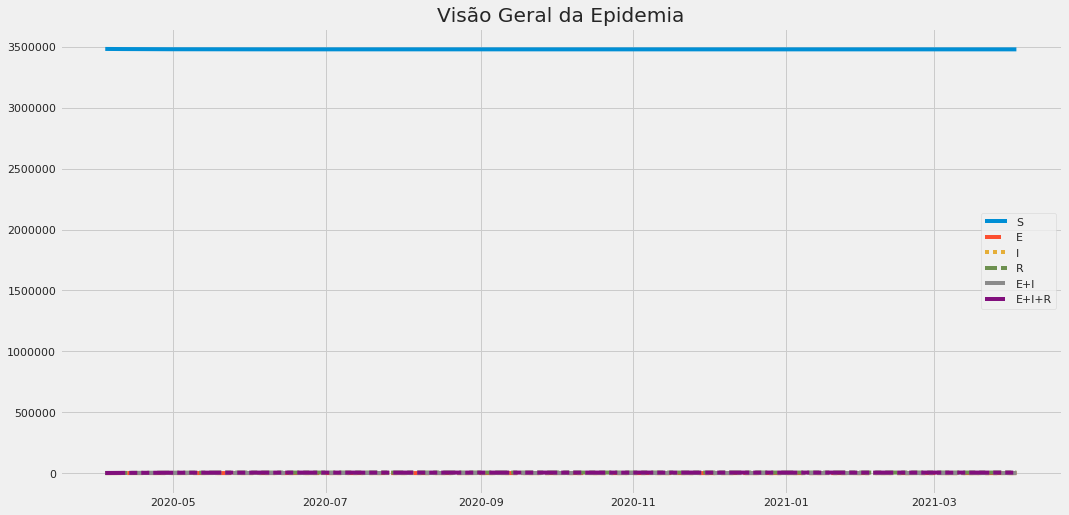

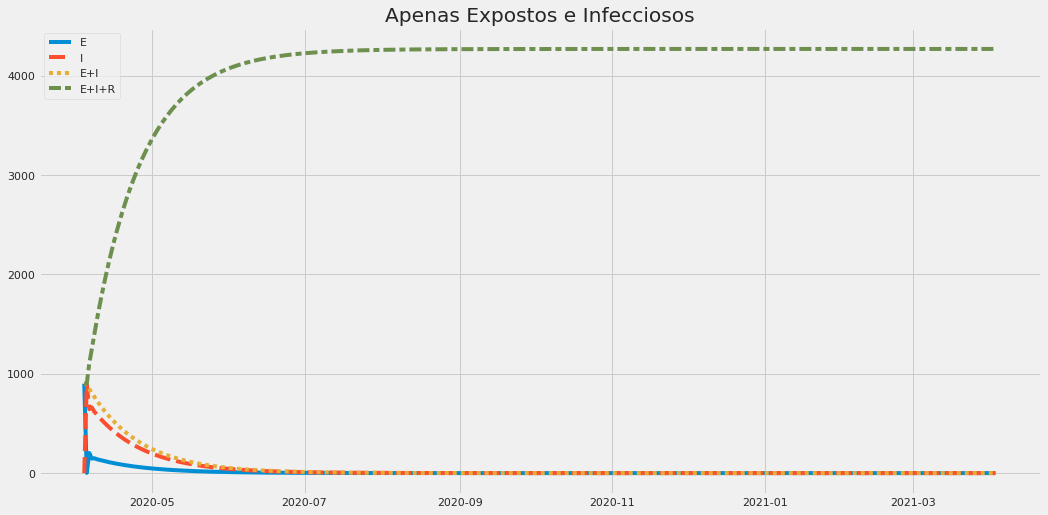

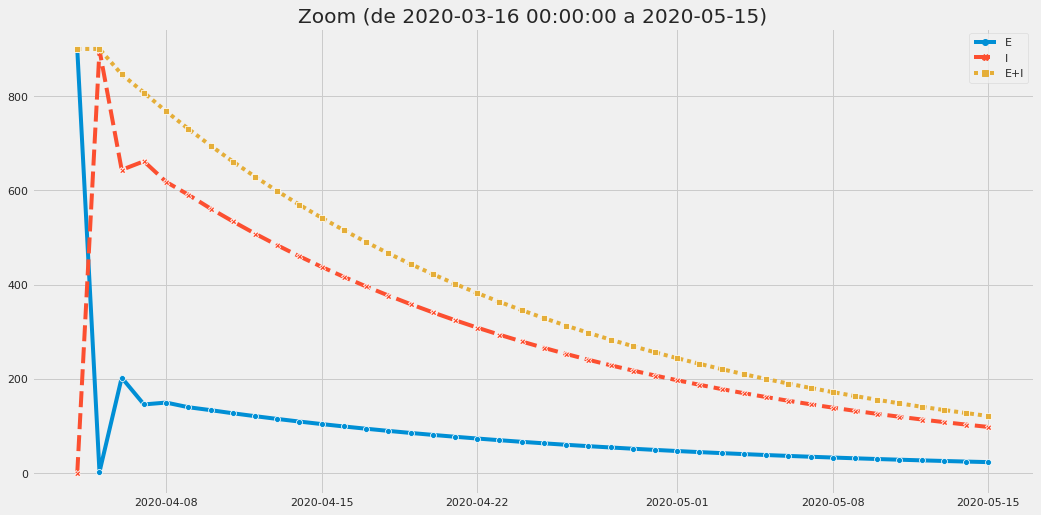

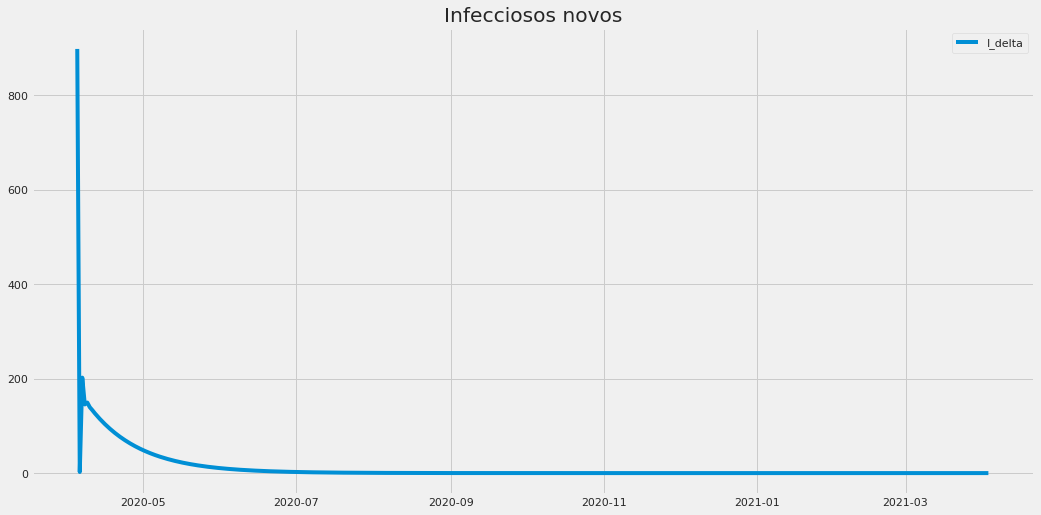

<Figure size 1152x576 with 0 Axes>

In [49]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [50]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,10,0,302,11,3484466.0,NaN,4530,NaN
2020-05-01,18,0,320,11,3484466.0,NaN,4800,NaN
2020-05-02,13,1,333,12,3484466.0,NaN,4995,NaN
2020-05-03,4,0,337,12,3484466.0,NaN,5055,NaN
2020-05-04,0,0,337,12,3484466.0,NaN,5055,NaN


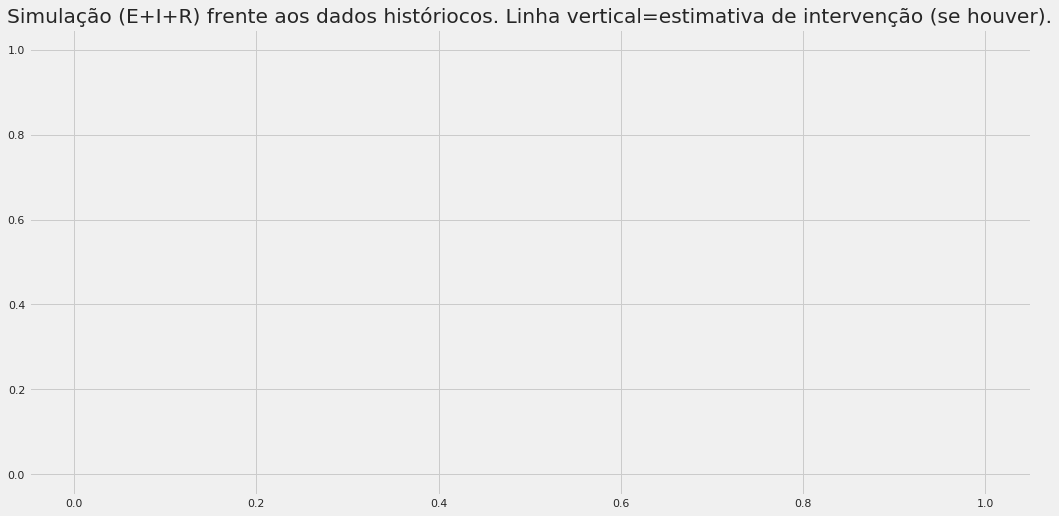

In [51]:
plot_curve_fitting(df_simulation_data=df_simulation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   comparison_date=pd.Timestamp('2020-04-01'),
                   best=best)

Salvemos os resultados.

In [52]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [53]:
## assuming different gammas
#
#space = \
#    {'dynamic':\
#        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_1', 1.0, 10.0)}, 
#           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_2', 1.0, 10.0)},
#         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_3', 1.0, 10.0)}], 
#        0, 60)
#    }

# assuming gamma_1 == gamma_2 == gamma_3
space = \
    {'dynamic':\
        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_1', 1.0, 20.0)}, 
           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_2', 1.0, 20.0)},
         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_3', 1.0, 20.0)}], 
        0, 60)
    }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 7/3000 [00:00<00:47, 62.95trial/s, best loss: 833.2020054270224]

  1%|          | 16/3000 [00:00<00:43, 68.50trial/s, best loss: 596.0301217153085]

  1%|          | 23/3000 [00:00<00:43, 68.40trial/s, best loss: 373.20337456701725]

  1%|          | 29/3000 [00:00<00:47, 62.82trial/s, best loss: 373.20337456701725]

  1%|          | 35/3000 [00:00<00:58, 50.93trial/s, best loss: 373.20337456701725]

  1%|▏         | 40/3000 [00:00<00:59, 49.50trial/s, best loss: 373.20337456701725]

  2%|▏         | 45/3000 [00:00<01:00, 49.06trial/s, best loss: 237.5489115344406] 

  2%|▏         | 50/3000 [00:00<01:01, 47.96trial/s, best loss: 237.5489115344406]

  2%|▏         | 55/3000 [00:01<01:00, 48.39trial/s, best loss: 237.5489115344406]

  2%|▏         | 60/3000 [00:01<01:00, 48.36trial/s, best loss: 237.5489115344406]

  2%|▏         | 65/3000 [00:01<01:00, 48.18trial/s, best loss: 237.5489115344406]

  2%|▏         | 70/3000 [00:01<01:00, 48.09trial/s, best loss: 237.5489115344406]

  2%|▎         | 75/3000 [00:01<01:01, 47.83trial/s, best loss: 92.46171789376825]

  3%|▎         | 80/3000 [00:01<01:01, 47.73trial/s, best loss: 92.46171789376825]

  3%|▎         | 85/3000 [00:01<01:02, 46.96trial/s, best loss: 92.46171789376825]

  3%|▎         | 90/3000 [00:01<01:03, 46.13trial/s, best loss: 92.46171789376825]

  3%|▎         | 95/3000 [00:01<01:02, 46.16trial/s, best loss: 92.46171789376825]

  3%|▎         | 100/3000 [00:01<01:04, 44.90trial/s, best loss: 92.46171789376825]

  4%|▎         | 105/3000 [00:02<01:10, 40.80trial/s, best loss: 92.46171789376825]

  4%|▎         | 110/3000 [00:02<01:08, 41.96trial/s, best loss: 92.46171789376825]

  4%|▍         | 115/3000 [00:02<01:06, 43.24trial/s, best loss: 92.46171789376825]

  4%|▍         | 120/3000 [00:02<01:05, 43.81trial/s, best loss: 92.46171789376825]

  4%|▍         | 125/3000 [00:02<01:04, 44.58trial/s, best loss: 92.46171789376825]

  4%|▍         | 130/3000 [00:02<01:03, 44.91trial/s, best loss: 92.46171789376825]

  4%|▍         | 135/3000 [00:02<01:06, 43.15trial/s, best loss: 92.46171789376825]

  5%|▍         | 140/3000 [00:02<01:09, 41.22trial/s, best loss: 92.46171789376825]

  5%|▍         | 145/3000 [00:03<01:07, 42.31trial/s, best loss: 92.46171789376825]

  5%|▌         | 150/3000 [00:03<01:06, 42.77trial/s, best loss: 92.46171789376825]

  5%|▌         | 155/3000 [00:03<01:06, 42.87trial/s, best loss: 92.46171789376825]

  5%|▌         | 160/3000 [00:03<01:05, 43.28trial/s, best loss: 92.46171789376825]

  6%|▌         | 165/3000 [00:03<01:04, 43.63trial/s, best loss: 92.46171789376825]

  6%|▌         | 170/3000 [00:03<01:04, 43.76trial/s, best loss: 92.46171789376825]

  6%|▌         | 175/3000 [00:03<01:05, 43.12trial/s, best loss: 92.46171789376825]

  6%|▌         | 180/3000 [00:03<01:09, 40.69trial/s, best loss: 92.46171789376825]

  6%|▌         | 185/3000 [00:04<01:13, 38.16trial/s, best loss: 92.46171789376825]

  6%|▋         | 190/3000 [00:04<01:13, 38.42trial/s, best loss: 92.46171789376825]

  6%|▋         | 195/3000 [00:04<01:10, 39.58trial/s, best loss: 92.46171789376825]

  7%|▋         | 199/3000 [00:04<01:20, 35.00trial/s, best loss: 92.46171789376825]

  7%|▋         | 204/3000 [00:04<01:15, 36.94trial/s, best loss: 92.46171789376825]

  7%|▋         | 208/3000 [00:04<01:15, 36.91trial/s, best loss: 92.46171789376825]

  7%|▋         | 212/3000 [00:04<01:15, 36.80trial/s, best loss: 92.46171789376825]

  7%|▋         | 217/3000 [00:04<01:12, 38.29trial/s, best loss: 92.46171789376825]

  7%|▋         | 221/3000 [00:04<01:13, 37.67trial/s, best loss: 92.46171789376825]

  8%|▊         | 226/3000 [00:05<01:11, 38.54trial/s, best loss: 92.46171789376825]

  8%|▊         | 230/3000 [00:05<01:13, 37.84trial/s, best loss: 92.46171789376825]

  8%|▊         | 235/3000 [00:05<01:11, 38.77trial/s, best loss: 92.46171789376825]

  8%|▊         | 240/3000 [00:05<01:09, 39.45trial/s, best loss: 92.46171789376825]

  8%|▊         | 245/3000 [00:05<01:09, 39.88trial/s, best loss: 92.46171789376825]

  8%|▊         | 250/3000 [00:05<01:08, 39.93trial/s, best loss: 92.46171789376825]

  8%|▊         | 255/3000 [00:05<01:10, 38.98trial/s, best loss: 92.46171789376825]

  9%|▊         | 259/3000 [00:05<01:17, 35.53trial/s, best loss: 92.46171789376825]

  9%|▉         | 263/3000 [00:06<01:21, 33.46trial/s, best loss: 92.46171789376825]

  9%|▉         | 267/3000 [00:06<01:19, 34.47trial/s, best loss: 92.46171789376825]

  9%|▉         | 271/3000 [00:06<01:16, 35.87trial/s, best loss: 92.46171789376825]

  9%|▉         | 275/3000 [00:06<01:13, 36.95trial/s, best loss: 92.46171789376825]

  9%|▉         | 279/3000 [00:06<01:12, 37.76trial/s, best loss: 92.46171789376825]

  9%|▉         | 283/3000 [00:06<01:10, 38.28trial/s, best loss: 92.46171789376825]

 10%|▉         | 287/3000 [00:06<01:11, 38.18trial/s, best loss: 92.46171789376825]

 10%|▉         | 291/3000 [00:06<01:10, 38.26trial/s, best loss: 92.46171789376825]

 10%|▉         | 295/3000 [00:06<01:13, 37.04trial/s, best loss: 92.46171789376825]

 10%|▉         | 299/3000 [00:07<01:12, 37.36trial/s, best loss: 92.46171789376825]

 10%|█         | 303/3000 [00:07<01:12, 37.46trial/s, best loss: 92.46171789376825]

 10%|█         | 307/3000 [00:07<01:11, 37.62trial/s, best loss: 92.46171789376825]

 10%|█         | 311/3000 [00:07<01:11, 37.83trial/s, best loss: 92.46171789376825]

 10%|█         | 315/3000 [00:07<01:11, 37.54trial/s, best loss: 92.46171789376825]

 11%|█         | 319/3000 [00:07<01:11, 37.57trial/s, best loss: 92.46171789376825]

 11%|█         | 323/3000 [00:07<01:11, 37.32trial/s, best loss: 92.46171789376825]

 11%|█         | 327/3000 [00:07<01:13, 36.55trial/s, best loss: 92.46171789376825]

 11%|█         | 331/3000 [00:07<01:14, 35.97trial/s, best loss: 92.46171789376825]

 11%|█         | 335/3000 [00:08<01:13, 36.16trial/s, best loss: 92.46171789376825]

 11%|█▏        | 339/3000 [00:08<01:13, 36.00trial/s, best loss: 92.46171789376825]

 11%|█▏        | 343/3000 [00:08<01:14, 35.56trial/s, best loss: 92.46171789376825]

 12%|█▏        | 347/3000 [00:08<01:18, 33.74trial/s, best loss: 92.46171789376825]

 12%|█▏        | 351/3000 [00:08<01:18, 33.56trial/s, best loss: 92.46171789376825]

 12%|█▏        | 355/3000 [00:08<01:19, 33.37trial/s, best loss: 92.46171789376825]

 12%|█▏        | 359/3000 [00:08<01:20, 32.95trial/s, best loss: 92.46171789376825]

 12%|█▏        | 363/3000 [00:08<01:23, 31.73trial/s, best loss: 92.46171789376825]

 12%|█▏        | 367/3000 [00:09<01:31, 28.77trial/s, best loss: 92.46171789376825]

 12%|█▏        | 371/3000 [00:09<01:29, 29.48trial/s, best loss: 92.46171789376825]

 12%|█▎        | 375/3000 [00:09<01:26, 30.18trial/s, best loss: 92.46171789376825]

 13%|█▎        | 379/3000 [00:09<01:30, 28.89trial/s, best loss: 92.46171789376825]

 13%|█▎        | 383/3000 [00:09<01:28, 29.70trial/s, best loss: 92.46171789376825]

 13%|█▎        | 387/3000 [00:09<01:26, 30.38trial/s, best loss: 92.46171789376825]

 13%|█▎        | 391/3000 [00:09<01:24, 30.73trial/s, best loss: 92.46171789376825]

 13%|█▎        | 395/3000 [00:09<01:24, 30.85trial/s, best loss: 92.46171789376825]

 13%|█▎        | 399/3000 [00:10<01:23, 31.29trial/s, best loss: 92.46171789376825]

 13%|█▎        | 403/3000 [00:10<01:22, 31.39trial/s, best loss: 92.46171789376825]

 14%|█▎        | 407/3000 [00:10<01:22, 31.56trial/s, best loss: 92.46171789376825]

 14%|█▎        | 411/3000 [00:10<01:21, 31.58trial/s, best loss: 92.46171789376825]

 14%|█▍        | 415/3000 [00:10<01:21, 31.56trial/s, best loss: 92.46171789376825]

 14%|█▍        | 419/3000 [00:10<01:22, 31.20trial/s, best loss: 92.46171789376825]

 14%|█▍        | 423/3000 [00:10<01:22, 31.11trial/s, best loss: 92.46171789376825]

 14%|█▍        | 427/3000 [00:11<01:25, 30.20trial/s, best loss: 92.46171789376825]

 14%|█▍        | 431/3000 [00:11<01:25, 30.22trial/s, best loss: 92.46171789376825]

 14%|█▍        | 435/3000 [00:11<01:24, 30.34trial/s, best loss: 92.46171789376825]

 15%|█▍        | 439/3000 [00:11<01:32, 27.66trial/s, best loss: 92.46171789376825]

 15%|█▍        | 443/3000 [00:11<01:29, 28.57trial/s, best loss: 92.46171789376825]

 15%|█▍        | 447/3000 [00:11<01:27, 29.08trial/s, best loss: 92.46171789376825]

 15%|█▌        | 450/3000 [00:11<01:27, 28.98trial/s, best loss: 92.46171789376825]

 15%|█▌        | 453/3000 [00:11<01:29, 28.54trial/s, best loss: 92.46171789376825]

 15%|█▌        | 456/3000 [00:12<01:28, 28.90trial/s, best loss: 92.46171789376825]

 15%|█▌        | 460/3000 [00:12<01:26, 29.20trial/s, best loss: 92.46171789376825]

 15%|█▌        | 463/3000 [00:12<01:27, 29.09trial/s, best loss: 92.46171789376825]

 16%|█▌        | 467/3000 [00:12<01:26, 29.33trial/s, best loss: 92.46171789376825]

 16%|█▌        | 470/3000 [00:12<01:25, 29.46trial/s, best loss: 92.46171789376825]

 16%|█▌        | 474/3000 [00:12<01:25, 29.65trial/s, best loss: 92.46171789376825]

 16%|█▌        | 477/3000 [00:12<01:25, 29.53trial/s, best loss: 92.46171789376825]

 16%|█▌        | 480/3000 [00:12<01:27, 28.90trial/s, best loss: 92.46171789376825]

 16%|█▌        | 483/3000 [00:12<01:32, 27.26trial/s, best loss: 92.46171789376825]

 16%|█▌        | 486/3000 [00:13<01:30, 27.87trial/s, best loss: 92.46171789376825]

 16%|█▋        | 489/3000 [00:13<01:29, 28.04trial/s, best loss: 92.46171789376825]

 16%|█▋        | 492/3000 [00:13<01:28, 28.31trial/s, best loss: 92.46171789376825]

 16%|█▋        | 495/3000 [00:13<01:28, 28.22trial/s, best loss: 92.46171789376825]

 17%|█▋        | 498/3000 [00:13<01:28, 28.37trial/s, best loss: 92.46171789376825]

 17%|█▋        | 501/3000 [00:13<01:27, 28.52trial/s, best loss: 92.46171789376825]

 17%|█▋        | 504/3000 [00:13<01:27, 28.46trial/s, best loss: 92.46171789376825]

 17%|█▋        | 507/3000 [00:13<01:29, 27.86trial/s, best loss: 92.46171789376825]

 17%|█▋        | 510/3000 [00:13<01:33, 26.60trial/s, best loss: 92.46171789376825]

 17%|█▋        | 513/3000 [00:14<01:31, 27.05trial/s, best loss: 92.46171789376825]

 17%|█▋        | 516/3000 [00:14<01:33, 26.48trial/s, best loss: 92.46171789376825]

 17%|█▋        | 519/3000 [00:14<01:32, 26.85trial/s, best loss: 92.46171789376825]

 17%|█▋        | 522/3000 [00:14<01:31, 27.21trial/s, best loss: 92.46171789376825]

 18%|█▊        | 525/3000 [00:14<01:30, 27.47trial/s, best loss: 92.46171789376825]

 18%|█▊        | 528/3000 [00:14<01:29, 27.72trial/s, best loss: 92.46171789376825]

 18%|█▊        | 531/3000 [00:14<01:28, 27.80trial/s, best loss: 92.46171789376825]

 18%|█▊        | 534/3000 [00:14<01:29, 27.57trial/s, best loss: 92.46171789376825]

 18%|█▊        | 537/3000 [00:14<01:44, 23.67trial/s, best loss: 92.46171789376825]

 18%|█▊        | 540/3000 [00:15<01:40, 24.57trial/s, best loss: 92.46171789376825]

 18%|█▊        | 543/3000 [00:15<01:37, 25.20trial/s, best loss: 92.46171789376825]

 18%|█▊        | 546/3000 [00:15<01:34, 25.87trial/s, best loss: 92.46171789376825]

 18%|█▊        | 549/3000 [00:15<01:32, 26.49trial/s, best loss: 92.46171789376825]

 18%|█▊        | 552/3000 [00:15<01:30, 26.91trial/s, best loss: 92.46171789376825]

 18%|█▊        | 555/3000 [00:15<01:29, 27.21trial/s, best loss: 92.46171789376825]

 19%|█▊        | 558/3000 [00:15<01:30, 27.05trial/s, best loss: 92.46171789376825]

 19%|█▊        | 561/3000 [00:15<01:32, 26.30trial/s, best loss: 92.46171789376825]

 19%|█▉        | 564/3000 [00:16<01:36, 25.28trial/s, best loss: 92.46171789376825]

 19%|█▉        | 567/3000 [00:16<01:34, 25.88trial/s, best loss: 92.46171789376825]

 19%|█▉        | 570/3000 [00:16<01:38, 24.61trial/s, best loss: 92.46171789376825]

 19%|█▉        | 573/3000 [00:16<01:36, 25.15trial/s, best loss: 92.46171789376825]

 19%|█▉        | 576/3000 [00:16<01:34, 25.52trial/s, best loss: 92.46171789376825]

 19%|█▉        | 579/3000 [00:16<01:34, 25.55trial/s, best loss: 92.46171789376825]

 19%|█▉        | 582/3000 [00:16<01:35, 25.35trial/s, best loss: 92.46171789376825]

 20%|█▉        | 585/3000 [00:16<01:34, 25.47trial/s, best loss: 92.46171789376825]

 20%|█▉        | 588/3000 [00:16<01:36, 25.08trial/s, best loss: 92.46171789376825]

 20%|█▉        | 591/3000 [00:17<01:34, 25.52trial/s, best loss: 92.46171789376825]

 20%|█▉        | 594/3000 [00:17<01:33, 25.79trial/s, best loss: 92.46171789376825]

 20%|█▉        | 597/3000 [00:17<01:32, 25.94trial/s, best loss: 92.46171789376825]

 20%|██        | 600/3000 [00:17<01:31, 26.10trial/s, best loss: 92.46171789376825]

 20%|██        | 603/3000 [00:17<01:31, 26.23trial/s, best loss: 92.46171789376825]

 20%|██        | 606/3000 [00:17<01:37, 24.49trial/s, best loss: 92.46171789376825]

 20%|██        | 609/3000 [00:17<01:36, 24.81trial/s, best loss: 92.46171789376825]

 20%|██        | 612/3000 [00:17<01:34, 25.30trial/s, best loss: 92.46171789376825]

 20%|██        | 615/3000 [00:18<01:34, 25.21trial/s, best loss: 92.46171789376825]

 21%|██        | 618/3000 [00:18<01:33, 25.56trial/s, best loss: 92.46171789376825]

 21%|██        | 621/3000 [00:18<01:35, 25.03trial/s, best loss: 92.46171789376825]

 21%|██        | 624/3000 [00:18<01:37, 24.30trial/s, best loss: 92.46171789376825]

 21%|██        | 627/3000 [00:18<01:35, 24.81trial/s, best loss: 92.46171789376825]

 21%|██        | 630/3000 [00:18<01:33, 25.37trial/s, best loss: 92.46171789376825]

 21%|██        | 633/3000 [00:18<01:32, 25.54trial/s, best loss: 92.46171789376825]

 21%|██        | 636/3000 [00:18<01:32, 25.55trial/s, best loss: 92.46171789376825]

 21%|██▏       | 639/3000 [00:18<01:34, 24.98trial/s, best loss: 92.46171789376825]

 21%|██▏       | 642/3000 [00:19<01:32, 25.42trial/s, best loss: 92.46171789376825]

 22%|██▏       | 645/3000 [00:19<01:32, 25.36trial/s, best loss: 92.46171789376825]

 22%|██▏       | 648/3000 [00:19<01:32, 25.55trial/s, best loss: 92.46171789376825]

 22%|██▏       | 651/3000 [00:19<01:31, 25.54trial/s, best loss: 92.46171789376825]

 22%|██▏       | 654/3000 [00:19<01:31, 25.69trial/s, best loss: 92.46171789376825]

 22%|██▏       | 657/3000 [00:19<01:30, 25.87trial/s, best loss: 92.46171789376825]

 22%|██▏       | 660/3000 [00:19<01:31, 25.55trial/s, best loss: 92.46171789376825]

 22%|██▏       | 663/3000 [00:19<01:34, 24.82trial/s, best loss: 92.46171789376825]

 22%|██▏       | 666/3000 [00:20<01:34, 24.73trial/s, best loss: 92.46171789376825]

 22%|██▏       | 669/3000 [00:20<01:33, 24.80trial/s, best loss: 92.46171789376825]

 22%|██▏       | 672/3000 [00:20<01:33, 24.95trial/s, best loss: 92.46171789376825]

 22%|██▎       | 675/3000 [00:20<01:32, 25.15trial/s, best loss: 92.46171789376825]

 23%|██▎       | 678/3000 [00:20<01:31, 25.33trial/s, best loss: 92.46171789376825]

 23%|██▎       | 681/3000 [00:20<01:30, 25.49trial/s, best loss: 92.46171789376825]

 23%|██▎       | 684/3000 [00:20<01:32, 25.15trial/s, best loss: 92.46171789376825]

 23%|██▎       | 687/3000 [00:20<01:32, 24.92trial/s, best loss: 92.46171789376825]

 23%|██▎       | 690/3000 [00:20<01:34, 24.47trial/s, best loss: 92.46171789376825]

 23%|██▎       | 693/3000 [00:21<01:33, 24.68trial/s, best loss: 92.46171789376825]

 23%|██▎       | 696/3000 [00:21<01:33, 24.61trial/s, best loss: 92.46171789376825]

 23%|██▎       | 699/3000 [00:21<01:33, 24.53trial/s, best loss: 92.46171789376825]

 23%|██▎       | 702/3000 [00:21<01:43, 22.23trial/s, best loss: 92.46171789376825]

 24%|██▎       | 705/3000 [00:21<01:40, 22.88trial/s, best loss: 92.46171789376825]

 24%|██▎       | 708/3000 [00:21<01:39, 23.12trial/s, best loss: 92.46171789376825]

 24%|██▎       | 711/3000 [00:21<01:39, 22.99trial/s, best loss: 92.46171789376825]

 24%|██▍       | 714/3000 [00:22<01:38, 23.30trial/s, best loss: 92.46171789376825]

 24%|██▍       | 717/3000 [00:22<01:37, 23.33trial/s, best loss: 92.46171789376825]

 24%|██▍       | 720/3000 [00:22<01:37, 23.33trial/s, best loss: 92.46171789376825]

 24%|██▍       | 723/3000 [00:22<01:36, 23.62trial/s, best loss: 92.46171789376825]

 24%|██▍       | 726/3000 [00:22<01:35, 23.80trial/s, best loss: 92.46171789376825]

 24%|██▍       | 729/3000 [00:22<01:34, 24.03trial/s, best loss: 92.46171789376825]

 24%|██▍       | 732/3000 [00:22<01:34, 23.89trial/s, best loss: 92.46171789376825]

 24%|██▍       | 735/3000 [00:22<01:36, 23.37trial/s, best loss: 92.46171789376825]

 25%|██▍       | 738/3000 [00:23<01:39, 22.80trial/s, best loss: 92.46171789376825]

 25%|██▍       | 741/3000 [00:23<01:38, 22.92trial/s, best loss: 92.46171789376825]

 25%|██▍       | 744/3000 [00:23<01:37, 23.13trial/s, best loss: 92.46171789376825]

 25%|██▍       | 747/3000 [00:23<01:36, 23.37trial/s, best loss: 92.46171789376825]

 25%|██▌       | 750/3000 [00:23<01:35, 23.59trial/s, best loss: 92.46171789376825]

 25%|██▌       | 753/3000 [00:23<01:34, 23.70trial/s, best loss: 92.46171789376825]

 25%|██▌       | 756/3000 [00:23<01:35, 23.43trial/s, best loss: 92.46171789376825]

 25%|██▌       | 759/3000 [00:23<01:37, 23.00trial/s, best loss: 92.46171789376825]

 25%|██▌       | 762/3000 [00:24<01:36, 23.13trial/s, best loss: 92.46171789376825]

 26%|██▌       | 765/3000 [00:24<01:38, 22.74trial/s, best loss: 92.46171789376825]

 26%|██▌       | 768/3000 [00:24<01:37, 22.81trial/s, best loss: 92.46171789376825]

 26%|██▌       | 771/3000 [00:24<01:37, 22.88trial/s, best loss: 92.46171789376825]

 26%|██▌       | 774/3000 [00:24<01:36, 23.04trial/s, best loss: 92.46171789376825]

 26%|██▌       | 777/3000 [00:24<01:36, 23.11trial/s, best loss: 92.46171789376825]

 26%|██▌       | 780/3000 [00:24<01:50, 20.02trial/s, best loss: 92.46171789376825]

 26%|██▌       | 783/3000 [00:25<01:46, 20.89trial/s, best loss: 92.46171789376825]

 26%|██▌       | 786/3000 [00:25<01:42, 21.52trial/s, best loss: 92.46171789376825]

 26%|██▋       | 789/3000 [00:25<01:40, 21.89trial/s, best loss: 92.46171789376825]

 26%|██▋       | 792/3000 [00:25<01:39, 22.12trial/s, best loss: 92.46171789376825]

 26%|██▋       | 795/3000 [00:25<01:38, 22.39trial/s, best loss: 92.46171789376825]

 27%|██▋       | 798/3000 [00:25<01:36, 22.73trial/s, best loss: 92.46171789376825]

 27%|██▋       | 801/3000 [00:25<01:39, 22.04trial/s, best loss: 92.46171789376825]

 27%|██▋       | 804/3000 [00:26<01:41, 21.67trial/s, best loss: 92.46171789376825]

 27%|██▋       | 807/3000 [00:26<01:40, 21.84trial/s, best loss: 92.46171789376825]

 27%|██▋       | 810/3000 [00:26<01:39, 22.09trial/s, best loss: 92.46171789376825]

 27%|██▋       | 813/3000 [00:26<01:37, 22.54trial/s, best loss: 92.46171789376825]

 27%|██▋       | 816/3000 [00:26<01:36, 22.74trial/s, best loss: 92.46171789376825]

 27%|██▋       | 819/3000 [00:26<01:35, 22.94trial/s, best loss: 92.46171789376825]

 27%|██▋       | 822/3000 [00:26<01:35, 22.77trial/s, best loss: 92.46171789376825]

 28%|██▊       | 825/3000 [00:26<01:40, 21.72trial/s, best loss: 92.46171789376825]

 28%|██▊       | 828/3000 [00:27<01:38, 22.07trial/s, best loss: 92.46171789376825]

 28%|██▊       | 831/3000 [00:27<01:38, 21.95trial/s, best loss: 92.46171789376825]

 28%|██▊       | 834/3000 [00:27<01:38, 22.02trial/s, best loss: 92.46171789376825]

 28%|██▊       | 837/3000 [00:27<01:37, 22.26trial/s, best loss: 92.46171789376825]

 28%|██▊       | 840/3000 [00:27<01:37, 22.14trial/s, best loss: 92.46171789376825]

 28%|██▊       | 843/3000 [00:27<01:37, 22.21trial/s, best loss: 92.46171789376825]

 28%|██▊       | 846/3000 [00:27<01:38, 21.93trial/s, best loss: 92.46171789376825]

 28%|██▊       | 849/3000 [00:28<01:38, 21.74trial/s, best loss: 92.46171789376825]

 28%|██▊       | 852/3000 [00:28<01:38, 21.77trial/s, best loss: 92.46171789376825]

 28%|██▊       | 855/3000 [00:28<01:38, 21.72trial/s, best loss: 92.46171789376825]

 29%|██▊       | 858/3000 [00:28<01:38, 21.81trial/s, best loss: 92.46171789376825]

 29%|██▊       | 861/3000 [00:28<01:48, 19.78trial/s, best loss: 92.46171789376825]

 29%|██▉       | 864/3000 [00:28<01:47, 19.94trial/s, best loss: 92.46171789376825]

 29%|██▉       | 867/3000 [00:28<01:45, 20.20trial/s, best loss: 92.46171789376825]

 29%|██▉       | 870/3000 [00:29<01:43, 20.61trial/s, best loss: 92.46171789376825]

 29%|██▉       | 873/3000 [00:29<01:42, 20.68trial/s, best loss: 92.46171789376825]

 29%|██▉       | 876/3000 [00:29<01:41, 20.96trial/s, best loss: 92.46171789376825]

 29%|██▉       | 879/3000 [00:29<01:40, 21.16trial/s, best loss: 92.46171789376825]

 29%|██▉       | 882/3000 [00:29<01:39, 21.34trial/s, best loss: 92.46171789376825]

 30%|██▉       | 885/3000 [00:29<01:38, 21.42trial/s, best loss: 92.46171789376825]

 30%|██▉       | 888/3000 [00:29<01:40, 20.96trial/s, best loss: 92.46171789376825]

 30%|██▉       | 891/3000 [00:30<01:41, 20.69trial/s, best loss: 92.46171789376825]

 30%|██▉       | 894/3000 [00:30<01:41, 20.82trial/s, best loss: 92.46171789376825]

 30%|██▉       | 897/3000 [00:30<01:40, 20.84trial/s, best loss: 92.46171789376825]

 30%|███       | 900/3000 [00:30<01:39, 21.01trial/s, best loss: 92.46171789376825]

 30%|███       | 903/3000 [00:30<01:39, 21.13trial/s, best loss: 92.46171789376825]

 30%|███       | 906/3000 [00:30<01:38, 21.17trial/s, best loss: 92.46171789376825]

 30%|███       | 909/3000 [00:30<01:41, 20.60trial/s, best loss: 92.46171789376825]

 30%|███       | 912/3000 [00:31<01:40, 20.80trial/s, best loss: 92.46171789376825]

 30%|███       | 915/3000 [00:31<01:39, 21.01trial/s, best loss: 92.46171789376825]

 31%|███       | 918/3000 [00:31<01:45, 19.78trial/s, best loss: 92.46171789376825]

 31%|███       | 921/3000 [00:31<01:42, 20.33trial/s, best loss: 92.46171789376825]

 31%|███       | 924/3000 [00:31<01:39, 20.83trial/s, best loss: 92.46171789376825]

 31%|███       | 927/3000 [00:31<01:38, 21.01trial/s, best loss: 92.46171789376825]

 31%|███       | 930/3000 [00:31<01:41, 20.31trial/s, best loss: 92.46171789376825]

 31%|███       | 933/3000 [00:32<01:41, 20.45trial/s, best loss: 92.46171789376825]

 31%|███       | 936/3000 [00:32<01:40, 20.51trial/s, best loss: 92.46171789376825]

 31%|███▏      | 939/3000 [00:32<01:39, 20.72trial/s, best loss: 92.46171789376825]

 31%|███▏      | 942/3000 [00:32<01:47, 19.11trial/s, best loss: 92.46171789376825]

 32%|███▏      | 945/3000 [00:32<01:44, 19.58trial/s, best loss: 92.46171789376825]

 32%|███▏      | 948/3000 [00:32<01:42, 19.93trial/s, best loss: 92.46171789376825]

 32%|███▏      | 951/3000 [00:33<01:46, 19.33trial/s, best loss: 92.46171789376825]

 32%|███▏      | 953/3000 [00:33<01:45, 19.46trial/s, best loss: 92.46171789376825]

 32%|███▏      | 955/3000 [00:33<01:45, 19.42trial/s, best loss: 92.46171789376825]

 32%|███▏      | 958/3000 [00:33<01:43, 19.78trial/s, best loss: 92.46171789376825]

 32%|███▏      | 961/3000 [00:33<01:41, 20.13trial/s, best loss: 92.46171789376825]

 32%|███▏      | 964/3000 [00:33<01:43, 19.68trial/s, best loss: 92.46171789376825]

 32%|███▏      | 966/3000 [00:33<01:56, 17.42trial/s, best loss: 92.46171789376825]

 32%|███▏      | 968/3000 [00:33<01:59, 17.05trial/s, best loss: 92.46171789376825]

 32%|███▏      | 971/3000 [00:34<01:52, 17.96trial/s, best loss: 92.46171789376825]

 32%|███▏      | 974/3000 [00:34<01:49, 18.53trial/s, best loss: 92.46171789376825]

 33%|███▎      | 976/3000 [00:34<01:46, 18.94trial/s, best loss: 92.46171789376825]

 33%|███▎      | 979/3000 [00:34<01:44, 19.39trial/s, best loss: 92.46171789376825]

 33%|███▎      | 982/3000 [00:34<01:41, 19.85trial/s, best loss: 92.46171789376825]

 33%|███▎      | 985/3000 [00:34<01:46, 18.94trial/s, best loss: 92.46171789376825]

 33%|███▎      | 987/3000 [00:34<01:46, 18.95trial/s, best loss: 92.46171789376825]

 33%|███▎      | 989/3000 [00:35<01:45, 19.15trial/s, best loss: 92.46171789376825]

 33%|███▎      | 991/3000 [00:35<01:43, 19.33trial/s, best loss: 92.46171789376825]

 33%|███▎      | 994/3000 [00:35<01:42, 19.66trial/s, best loss: 92.46171789376825]

 33%|███▎      | 997/3000 [00:35<01:40, 19.89trial/s, best loss: 92.46171789376825]

 33%|███▎      | 1000/3000 [00:35<01:39, 20.17trial/s, best loss: 92.46171789376825]

 33%|███▎      | 1003/3000 [00:35<01:38, 20.36trial/s, best loss: 92.46171789376825]

 34%|███▎      | 1006/3000 [00:35<01:38, 20.29trial/s, best loss: 92.46171789376825]

 34%|███▎      | 1009/3000 [00:35<01:40, 19.85trial/s, best loss: 92.46171789376825]

 34%|███▎      | 1012/3000 [00:36<01:39, 20.00trial/s, best loss: 92.46171789376825]

 34%|███▍      | 1015/3000 [00:36<01:38, 20.08trial/s, best loss: 92.46171789376825]

 34%|███▍      | 1018/3000 [00:36<01:38, 20.20trial/s, best loss: 92.46171789376825]

 34%|███▍      | 1021/3000 [00:36<01:37, 20.32trial/s, best loss: 92.46171789376825]

 34%|███▍      | 1024/3000 [00:36<01:46, 18.63trial/s, best loss: 92.46171789376825]

 34%|███▍      | 1027/3000 [00:36<01:44, 18.95trial/s, best loss: 92.46171789376825]

 34%|███▍      | 1030/3000 [00:37<01:42, 19.19trial/s, best loss: 92.46171789376825]

 34%|███▍      | 1032/3000 [00:37<01:41, 19.36trial/s, best loss: 92.46171789376825]

 34%|███▍      | 1034/3000 [00:37<01:41, 19.43trial/s, best loss: 92.46171789376825]

 35%|███▍      | 1036/3000 [00:37<01:40, 19.50trial/s, best loss: 92.46171789376825]

 35%|███▍      | 1038/3000 [00:37<01:40, 19.47trial/s, best loss: 92.46171789376825]

 35%|███▍      | 1040/3000 [00:37<01:40, 19.59trial/s, best loss: 92.46171789376825]

 35%|███▍      | 1043/3000 [00:37<01:38, 19.80trial/s, best loss: 92.46171789376825]

 35%|███▍      | 1045/3000 [00:37<01:39, 19.60trial/s, best loss: 92.46171789376825]

 35%|███▍      | 1047/3000 [00:37<01:43, 18.89trial/s, best loss: 92.46171789376825]

 35%|███▍      | 1049/3000 [00:38<01:42, 19.03trial/s, best loss: 92.46171789376825]

 35%|███▌      | 1051/3000 [00:38<01:41, 19.21trial/s, best loss: 92.46171789376825]

 35%|███▌      | 1053/3000 [00:38<01:40, 19.42trial/s, best loss: 92.46171789376825]

 35%|███▌      | 1055/3000 [00:38<01:39, 19.56trial/s, best loss: 92.46171789376825]

 35%|███▌      | 1058/3000 [00:38<01:38, 19.74trial/s, best loss: 92.46171789376825]

 35%|███▌      | 1061/3000 [00:38<01:37, 19.91trial/s, best loss: 92.46171789376825]

 35%|███▌      | 1064/3000 [00:38<01:37, 19.90trial/s, best loss: 92.46171789376825]

 36%|███▌      | 1066/3000 [00:38<01:37, 19.75trial/s, best loss: 92.46171789376825]

 36%|███▌      | 1068/3000 [00:39<01:37, 19.80trial/s, best loss: 92.46171789376825]

 36%|███▌      | 1070/3000 [00:39<01:37, 19.80trial/s, best loss: 92.46171789376825]

 36%|███▌      | 1072/3000 [00:39<01:37, 19.79trial/s, best loss: 92.46171789376825]

 36%|███▌      | 1074/3000 [00:39<01:37, 19.67trial/s, best loss: 92.46171789376825]

 36%|███▌      | 1076/3000 [00:39<01:37, 19.65trial/s, best loss: 92.46171789376825]

 36%|███▌      | 1078/3000 [00:39<01:38, 19.58trial/s, best loss: 92.46171789376825]

 36%|███▌      | 1080/3000 [00:39<01:38, 19.55trial/s, best loss: 92.46171789376825]

 36%|███▌      | 1082/3000 [00:39<01:37, 19.59trial/s, best loss: 92.46171789376825]

 36%|███▌      | 1084/3000 [00:39<01:39, 19.26trial/s, best loss: 92.46171789376825]

 36%|███▌      | 1086/3000 [00:39<01:40, 18.99trial/s, best loss: 92.46171789376825]

 36%|███▋      | 1088/3000 [00:40<01:39, 19.16trial/s, best loss: 92.46171789376825]

 36%|███▋      | 1090/3000 [00:40<01:39, 19.16trial/s, best loss: 92.46171789376825]

 36%|███▋      | 1092/3000 [00:40<01:41, 18.77trial/s, best loss: 92.46171789376825]

 36%|███▋      | 1094/3000 [00:40<01:41, 18.82trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1096/3000 [00:40<01:42, 18.63trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1098/3000 [00:40<01:42, 18.47trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1100/3000 [00:40<01:43, 18.42trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1102/3000 [00:40<01:44, 18.12trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1104/3000 [00:40<01:52, 16.83trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1106/3000 [00:41<01:50, 17.16trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1108/3000 [00:41<02:05, 15.07trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1110/3000 [00:41<01:58, 15.90trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1112/3000 [00:41<01:54, 16.43trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1114/3000 [00:41<01:51, 16.93trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1116/3000 [00:41<01:48, 17.44trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1118/3000 [00:41<01:46, 17.59trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1120/3000 [00:41<01:50, 17.00trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1122/3000 [00:42<01:50, 17.03trial/s, best loss: 92.46171789376825]

 37%|███▋      | 1124/3000 [00:42<01:48, 17.23trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1126/3000 [00:42<01:46, 17.60trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1128/3000 [00:42<01:44, 17.97trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1130/3000 [00:42<01:42, 18.25trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1132/3000 [00:42<01:40, 18.52trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1134/3000 [00:42<01:40, 18.65trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1136/3000 [00:42<01:39, 18.72trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1138/3000 [00:42<01:40, 18.50trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1140/3000 [00:43<01:43, 17.94trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1142/3000 [00:43<01:42, 18.10trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1144/3000 [00:43<01:43, 17.94trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1146/3000 [00:43<01:44, 17.78trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1148/3000 [00:43<01:42, 18.07trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1150/3000 [00:43<01:41, 18.26trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1152/3000 [00:43<01:39, 18.53trial/s, best loss: 92.46171789376825]

 38%|███▊      | 1154/3000 [00:43<01:39, 18.61trial/s, best loss: 92.46171789376825]

 39%|███▊      | 1156/3000 [00:43<01:40, 18.26trial/s, best loss: 92.46171789376825]

 39%|███▊      | 1158/3000 [00:44<01:43, 17.73trial/s, best loss: 92.46171789376825]

 39%|███▊      | 1160/3000 [00:44<01:41, 18.09trial/s, best loss: 92.46171789376825]

 39%|███▊      | 1162/3000 [00:44<01:40, 18.20trial/s, best loss: 92.46171789376825]

 39%|███▉      | 1164/3000 [00:44<01:40, 18.26trial/s, best loss: 92.46171789376825]

 39%|███▉      | 1166/3000 [00:44<01:39, 18.51trial/s, best loss: 92.46171789376825]

 39%|███▉      | 1168/3000 [00:44<01:37, 18.72trial/s, best loss: 92.46171789376825]

 39%|███▉      | 1170/3000 [00:44<01:37, 18.74trial/s, best loss: 92.46171789376825]

 39%|███▉      | 1172/3000 [00:44<01:37, 18.78trial/s, best loss: 92.46171789376825]

 39%|███▉      | 1174/3000 [00:44<01:39, 18.31trial/s, best loss: 92.46171789376825]

 39%|███▉      | 1176/3000 [00:44<01:43, 17.57trial/s, best loss: 92.46171789376825]

 39%|███▉      | 1178/3000 [00:45<01:42, 17.72trial/s, best loss: 92.46171789376825]

 39%|███▉      | 1180/3000 [00:45<01:43, 17.57trial/s, best loss: 92.46171789376825]

 39%|███▉      | 1182/3000 [00:45<01:42, 17.69trial/s, best loss: 92.46171789376825]

 39%|███▉      | 1184/3000 [00:45<01:42, 17.65trial/s, best loss: 92.46171789376825]

 40%|███▉      | 1186/3000 [00:45<01:41, 17.80trial/s, best loss: 92.46171789376825]

 40%|███▉      | 1188/3000 [00:45<01:50, 16.44trial/s, best loss: 92.46171789376825]

 40%|███▉      | 1190/3000 [00:45<01:54, 15.83trial/s, best loss: 92.46171789376825]

 40%|███▉      | 1192/3000 [00:45<01:53, 15.88trial/s, best loss: 92.46171789376825]

 40%|███▉      | 1194/3000 [00:46<01:50, 16.31trial/s, best loss: 92.46171789376825]

 40%|███▉      | 1196/3000 [00:46<01:48, 16.62trial/s, best loss: 92.46171789376825]

 40%|███▉      | 1198/3000 [00:46<01:47, 16.83trial/s, best loss: 92.46171789376825]

 40%|████      | 1200/3000 [00:46<01:46, 16.84trial/s, best loss: 92.46171789376825]

 40%|████      | 1202/3000 [00:46<01:47, 16.80trial/s, best loss: 92.46171789376825]

 40%|████      | 1204/3000 [00:46<01:46, 16.81trial/s, best loss: 92.46171789376825]

 40%|████      | 1206/3000 [00:46<01:44, 17.15trial/s, best loss: 92.46171789376825]

 40%|████      | 1208/3000 [00:46<01:43, 17.34trial/s, best loss: 92.46171789376825]

 40%|████      | 1210/3000 [00:47<01:45, 16.98trial/s, best loss: 92.46171789376825]

 40%|████      | 1212/3000 [00:47<01:42, 17.42trial/s, best loss: 92.46171789376825]

 40%|████      | 1214/3000 [00:47<01:40, 17.71trial/s, best loss: 92.46171789376825]

 41%|████      | 1216/3000 [00:47<01:39, 17.91trial/s, best loss: 92.46171789376825]

 41%|████      | 1218/3000 [00:47<01:38, 18.14trial/s, best loss: 92.46171789376825]

 41%|████      | 1220/3000 [00:47<01:37, 18.22trial/s, best loss: 92.46171789376825]

 41%|████      | 1222/3000 [00:47<01:37, 18.18trial/s, best loss: 92.46171789376825]

 41%|████      | 1224/3000 [00:47<01:37, 18.25trial/s, best loss: 92.46171789376825]

 41%|████      | 1226/3000 [00:47<01:38, 18.02trial/s, best loss: 92.46171789376825]

 41%|████      | 1228/3000 [00:47<01:40, 17.64trial/s, best loss: 92.46171789376825]

 41%|████      | 1230/3000 [00:48<01:39, 17.81trial/s, best loss: 92.46171789376825]

 41%|████      | 1232/3000 [00:48<01:38, 17.89trial/s, best loss: 92.46171789376825]

 41%|████      | 1234/3000 [00:48<01:38, 17.92trial/s, best loss: 92.46171789376825]

 41%|████      | 1236/3000 [00:48<01:38, 17.88trial/s, best loss: 92.46171789376825]

 41%|████▏     | 1238/3000 [00:48<01:37, 18.12trial/s, best loss: 92.46171789376825]

 41%|████▏     | 1240/3000 [00:48<01:36, 18.20trial/s, best loss: 92.46171789376825]

 41%|████▏     | 1242/3000 [00:48<01:36, 18.25trial/s, best loss: 92.46171789376825]

 41%|████▏     | 1244/3000 [00:48<01:37, 18.08trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1246/3000 [00:48<01:37, 17.90trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1248/3000 [00:49<01:37, 17.97trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1250/3000 [00:49<01:37, 17.98trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1252/3000 [00:49<01:36, 18.06trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1254/3000 [00:49<01:48, 16.02trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1256/3000 [00:49<01:44, 16.65trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1258/3000 [00:49<01:41, 17.11trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1260/3000 [00:49<01:41, 17.22trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1262/3000 [00:49<01:44, 16.58trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1264/3000 [00:50<01:41, 17.06trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1266/3000 [00:50<01:39, 17.35trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1268/3000 [00:50<01:38, 17.55trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1270/3000 [00:50<01:37, 17.72trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1272/3000 [00:50<01:36, 17.89trial/s, best loss: 92.46171789376825]

 42%|████▏     | 1274/3000 [00:50<01:36, 17.93trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1276/3000 [00:50<01:36, 17.92trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1278/3000 [00:50<01:37, 17.74trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1280/3000 [00:50<01:42, 16.70trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1282/3000 [00:51<01:40, 17.04trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1284/3000 [00:51<01:39, 17.26trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1286/3000 [00:51<01:39, 17.20trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1288/3000 [00:51<01:38, 17.41trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1290/3000 [00:51<01:37, 17.54trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1292/3000 [00:51<01:37, 17.56trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1294/3000 [00:51<01:36, 17.60trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1296/3000 [00:51<01:38, 17.32trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1298/3000 [00:52<01:40, 16.99trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1300/3000 [00:52<01:38, 17.17trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1302/3000 [00:52<01:40, 16.81trial/s, best loss: 92.46171789376825]

 43%|████▎     | 1304/3000 [00:52<01:39, 17.09trial/s, best loss: 92.46171789376825]

 44%|████▎     | 1306/3000 [00:52<01:38, 17.28trial/s, best loss: 92.46171789376825]

 44%|████▎     | 1308/3000 [00:52<01:36, 17.45trial/s, best loss: 92.46171789376825]

 44%|████▎     | 1310/3000 [00:52<01:35, 17.61trial/s, best loss: 92.46171789376825]

 44%|████▎     | 1312/3000 [00:52<01:36, 17.54trial/s, best loss: 92.46171789376825]

 44%|████▍     | 1314/3000 [00:52<01:50, 15.23trial/s, best loss: 92.46171789376825]

 44%|████▍     | 1316/3000 [00:53<01:45, 15.90trial/s, best loss: 92.46171789376825]

 44%|████▍     | 1318/3000 [00:53<01:43, 16.33trial/s, best loss: 92.46171789376825]

 44%|████▍     | 1320/3000 [00:53<01:42, 16.44trial/s, best loss: 92.46171789376825]

 44%|████▍     | 1322/3000 [00:53<01:42, 16.39trial/s, best loss: 92.46171789376825]

 44%|████▍     | 1324/3000 [00:53<01:40, 16.69trial/s, best loss: 92.46171789376825]

 44%|████▍     | 1326/3000 [00:53<01:38, 17.00trial/s, best loss: 92.46171789376825]

 44%|████▍     | 1328/3000 [00:53<01:37, 17.19trial/s, best loss: 92.46171789376825]

 44%|████▍     | 1330/3000 [00:53<01:42, 16.33trial/s, best loss: 92.46171789376825]

 44%|████▍     | 1332/3000 [00:54<01:41, 16.51trial/s, best loss: 92.46171789376825]

 44%|████▍     | 1334/3000 [00:54<01:38, 16.88trial/s, best loss: 92.46171789376825]

 45%|████▍     | 1336/3000 [00:54<01:38, 16.90trial/s, best loss: 92.46171789376825]

 45%|████▍     | 1338/3000 [00:54<01:37, 16.98trial/s, best loss: 92.46171789376825]

 45%|████▍     | 1340/3000 [00:54<01:37, 17.01trial/s, best loss: 92.46171789376825]

 45%|████▍     | 1342/3000 [00:54<01:37, 17.06trial/s, best loss: 92.46171789376825]

 45%|████▍     | 1344/3000 [00:54<01:36, 17.16trial/s, best loss: 92.46171789376825]

 45%|████▍     | 1346/3000 [00:54<01:37, 16.94trial/s, best loss: 92.46171789376825]

 45%|████▍     | 1348/3000 [00:55<01:52, 14.70trial/s, best loss: 92.46171789376825]

 45%|████▌     | 1350/3000 [00:55<01:48, 15.17trial/s, best loss: 92.46171789376825]

 45%|████▌     | 1352/3000 [00:55<01:44, 15.76trial/s, best loss: 92.46171789376825]

 45%|████▌     | 1354/3000 [00:55<01:41, 16.21trial/s, best loss: 92.46171789376825]

 45%|████▌     | 1356/3000 [00:55<01:39, 16.52trial/s, best loss: 92.46171789376825]

 45%|████▌     | 1358/3000 [00:55<01:37, 16.81trial/s, best loss: 92.46171789376825]

 45%|████▌     | 1360/3000 [00:55<01:37, 16.89trial/s, best loss: 92.46171789376825]

 45%|████▌     | 1362/3000 [00:55<01:38, 16.70trial/s, best loss: 92.46171789376825]

 45%|████▌     | 1364/3000 [00:55<01:39, 16.52trial/s, best loss: 92.46171789376825]

 46%|████▌     | 1366/3000 [00:56<01:37, 16.69trial/s, best loss: 92.46171789376825]

 46%|████▌     | 1368/3000 [00:56<01:37, 16.73trial/s, best loss: 92.46171789376825]

 46%|████▌     | 1370/3000 [00:56<01:37, 16.78trial/s, best loss: 92.46171789376825]

 46%|████▌     | 1372/3000 [00:56<01:36, 16.92trial/s, best loss: 92.46171789376825]

 46%|████▌     | 1374/3000 [00:56<01:35, 17.02trial/s, best loss: 92.46171789376825]

 46%|████▌     | 1376/3000 [00:56<01:35, 17.02trial/s, best loss: 92.46171789376825]

 46%|████▌     | 1378/3000 [00:56<01:35, 16.91trial/s, best loss: 92.46171789376825]

 46%|████▌     | 1380/3000 [00:56<01:37, 16.56trial/s, best loss: 92.46171789376825]

 46%|████▌     | 1382/3000 [00:57<01:37, 16.65trial/s, best loss: 92.46171789376825]

 46%|████▌     | 1384/3000 [00:57<01:38, 16.40trial/s, best loss: 92.46171789376825]

 46%|████▌     | 1386/3000 [00:57<01:37, 16.48trial/s, best loss: 92.46171789376825]

 46%|████▋     | 1388/3000 [00:57<01:37, 16.61trial/s, best loss: 92.46171789376825]

 46%|████▋     | 1390/3000 [00:57<01:36, 16.72trial/s, best loss: 92.46171789376825]

 46%|████▋     | 1392/3000 [00:57<01:35, 16.86trial/s, best loss: 92.46171789376825]

 46%|████▋     | 1394/3000 [00:57<01:34, 16.91trial/s, best loss: 92.46171789376825]

 47%|████▋     | 1396/3000 [00:57<01:36, 16.70trial/s, best loss: 92.46171789376825]

 47%|████▋     | 1398/3000 [00:58<01:51, 14.40trial/s, best loss: 92.46171789376825]

 47%|████▋     | 1400/3000 [00:58<01:46, 15.05trial/s, best loss: 92.46171789376825]

 47%|████▋     | 1402/3000 [00:58<01:42, 15.54trial/s, best loss: 92.46171789376825]

 47%|████▋     | 1404/3000 [00:58<01:40, 15.83trial/s, best loss: 92.46171789376825]

 47%|████▋     | 1406/3000 [00:58<01:38, 16.13trial/s, best loss: 92.46171789376825]

 47%|████▋     | 1408/3000 [00:58<01:37, 16.32trial/s, best loss: 92.46171789376825]

 47%|████▋     | 1410/3000 [00:58<01:36, 16.47trial/s, best loss: 92.46171789376825]

 47%|████▋     | 1412/3000 [00:58<01:38, 16.20trial/s, best loss: 92.46171789376825]

 47%|████▋     | 1414/3000 [00:59<01:36, 16.37trial/s, best loss: 92.46171789376825]

 47%|████▋     | 1416/3000 [00:59<01:35, 16.52trial/s, best loss: 92.46171789376825]

 47%|████▋     | 1418/3000 [00:59<01:36, 16.43trial/s, best loss: 89.22425249261522]

 47%|████▋     | 1420/3000 [00:59<01:36, 16.33trial/s, best loss: 89.22425249261522]

 47%|████▋     | 1422/3000 [00:59<01:35, 16.45trial/s, best loss: 89.22425249261522]

 47%|████▋     | 1424/3000 [00:59<01:35, 16.48trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1426/3000 [00:59<01:34, 16.62trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1428/3000 [00:59<01:36, 16.37trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1430/3000 [01:00<01:37, 16.12trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1432/3000 [01:00<01:36, 16.25trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1434/3000 [01:00<01:36, 16.31trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1436/3000 [01:00<01:36, 16.18trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1438/3000 [01:00<01:50, 14.19trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1440/3000 [01:00<01:45, 14.78trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1442/3000 [01:00<01:43, 15.12trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1444/3000 [01:00<01:45, 14.73trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1446/3000 [01:01<01:42, 15.19trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1448/3000 [01:01<01:40, 15.44trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1450/3000 [01:01<01:40, 15.45trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1452/3000 [01:01<01:39, 15.50trial/s, best loss: 89.22425249261522]

 48%|████▊     | 1454/3000 [01:01<01:46, 14.49trial/s, best loss: 89.22425249261522]

 49%|████▊     | 1456/3000 [01:01<01:48, 14.25trial/s, best loss: 89.22425249261522]

 49%|████▊     | 1458/3000 [01:01<01:48, 14.23trial/s, best loss: 89.22425249261522]

 49%|████▊     | 1460/3000 [01:02<01:47, 14.31trial/s, best loss: 89.22425249261522]

 49%|████▊     | 1462/3000 [01:02<01:44, 14.79trial/s, best loss: 89.22425249261522]

 49%|████▉     | 1464/3000 [01:02<01:42, 15.02trial/s, best loss: 89.22425249261522]

 49%|████▉     | 1466/3000 [01:02<01:40, 15.28trial/s, best loss: 89.22425249261522]

 49%|████▉     | 1468/3000 [01:02<01:38, 15.55trial/s, best loss: 89.22425249261522]

 49%|████▉     | 1470/3000 [01:02<01:37, 15.74trial/s, best loss: 89.22425249261522]

 49%|████▉     | 1472/3000 [01:02<01:35, 15.92trial/s, best loss: 89.22425249261522]

 49%|████▉     | 1474/3000 [01:02<01:37, 15.64trial/s, best loss: 89.22425249261522]

 49%|████▉     | 1476/3000 [01:03<01:36, 15.72trial/s, best loss: 89.22425249261522]

 49%|████▉     | 1478/3000 [01:03<01:35, 15.88trial/s, best loss: 89.22425249261522]

 49%|████▉     | 1480/3000 [01:03<01:36, 15.82trial/s, best loss: 89.22425249261522]

 49%|████▉     | 1482/3000 [01:03<01:51, 13.63trial/s, best loss: 89.22425249261522]

 49%|████▉     | 1484/3000 [01:03<01:48, 13.98trial/s, best loss: 89.22425249261522]

 50%|████▉     | 1486/3000 [01:03<01:48, 13.89trial/s, best loss: 89.22425249261522]

 50%|████▉     | 1488/3000 [01:03<01:54, 13.17trial/s, best loss: 89.22425249261522]

 50%|████▉     | 1490/3000 [01:04<01:57, 12.89trial/s, best loss: 89.22425249261522]

 50%|████▉     | 1492/3000 [01:04<01:50, 13.69trial/s, best loss: 89.22425249261522]

 50%|████▉     | 1494/3000 [01:04<01:45, 14.21trial/s, best loss: 89.22425249261522]

 50%|████▉     | 1496/3000 [01:04<01:42, 14.61trial/s, best loss: 89.22425249261522]

 50%|████▉     | 1498/3000 [01:04<01:40, 14.93trial/s, best loss: 89.22425249261522]

 50%|█████     | 1500/3000 [01:04<01:38, 15.24trial/s, best loss: 89.22425249261522]

 50%|█████     | 1502/3000 [01:04<01:41, 14.79trial/s, best loss: 89.22425249261522]

 50%|█████     | 1504/3000 [01:05<01:46, 14.06trial/s, best loss: 89.22425249261522]

 50%|█████     | 1506/3000 [01:05<01:47, 13.90trial/s, best loss: 89.22425249261522]

 50%|█████     | 1508/3000 [01:05<01:47, 13.92trial/s, best loss: 89.22425249261522]

 50%|█████     | 1510/3000 [01:05<01:44, 14.23trial/s, best loss: 89.22425249261522]

 50%|█████     | 1512/3000 [01:05<01:42, 14.57trial/s, best loss: 89.22425249261522]

 50%|█████     | 1514/3000 [01:05<01:39, 14.95trial/s, best loss: 89.22425249261522]

 51%|█████     | 1516/3000 [01:05<01:38, 15.06trial/s, best loss: 89.22425249261522]

 51%|█████     | 1518/3000 [01:06<01:46, 13.88trial/s, best loss: 89.22425249261522]

 51%|█████     | 1520/3000 [01:06<01:45, 14.01trial/s, best loss: 89.22425249261522]

 51%|█████     | 1522/3000 [01:06<01:42, 14.39trial/s, best loss: 89.22425249261522]

 51%|█████     | 1524/3000 [01:06<01:52, 13.13trial/s, best loss: 89.22425249261522]

 51%|█████     | 1526/3000 [01:06<01:47, 13.71trial/s, best loss: 89.22425249261522]

 51%|█████     | 1528/3000 [01:06<01:44, 14.14trial/s, best loss: 89.22425249261522]

 51%|█████     | 1530/3000 [01:06<01:42, 14.34trial/s, best loss: 89.22425249261522]

 51%|█████     | 1532/3000 [01:07<01:43, 14.25trial/s, best loss: 89.22425249261522]

 51%|█████     | 1534/3000 [01:07<01:41, 14.49trial/s, best loss: 89.22425249261522]

 51%|█████     | 1536/3000 [01:07<01:39, 14.67trial/s, best loss: 89.22425249261522]

 51%|█████▏    | 1538/3000 [01:07<01:38, 14.89trial/s, best loss: 89.22425249261522]

 51%|█████▏    | 1540/3000 [01:07<01:37, 14.98trial/s, best loss: 89.22425249261522]

 51%|█████▏    | 1542/3000 [01:07<01:37, 14.97trial/s, best loss: 89.22425249261522]

 51%|█████▏    | 1544/3000 [01:07<01:35, 15.19trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1546/3000 [01:07<01:39, 14.55trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1548/3000 [01:08<01:39, 14.55trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1550/3000 [01:08<01:41, 14.34trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1552/3000 [01:08<01:41, 14.30trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1554/3000 [01:08<01:40, 14.33trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1556/3000 [01:08<01:38, 14.59trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1558/3000 [01:08<01:37, 14.85trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1560/3000 [01:08<01:39, 14.49trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1562/3000 [01:09<01:39, 14.51trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1564/3000 [01:09<01:39, 14.40trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1566/3000 [01:09<01:39, 14.47trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1568/3000 [01:09<01:53, 12.65trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1570/3000 [01:09<01:46, 13.39trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1572/3000 [01:09<01:42, 13.91trial/s, best loss: 89.22425249261522]

 52%|█████▏    | 1574/3000 [01:09<01:43, 13.84trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1576/3000 [01:10<01:39, 14.27trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1578/3000 [01:10<01:38, 14.39trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1580/3000 [01:10<01:38, 14.48trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1582/3000 [01:10<01:36, 14.67trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1584/3000 [01:10<01:34, 14.95trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1586/3000 [01:10<01:33, 15.14trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1588/3000 [01:10<01:34, 14.92trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1590/3000 [01:11<01:37, 14.44trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1592/3000 [01:11<01:36, 14.62trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1594/3000 [01:11<01:35, 14.70trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1596/3000 [01:11<01:34, 14.84trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1598/3000 [01:11<01:35, 14.69trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1600/3000 [01:11<01:34, 14.87trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1602/3000 [01:11<01:34, 14.86trial/s, best loss: 89.22425249261522]

 53%|█████▎    | 1604/3000 [01:11<01:35, 14.55trial/s, best loss: 89.22425249261522]

 54%|█████▎    | 1606/3000 [01:12<01:34, 14.81trial/s, best loss: 89.22425249261522]

 54%|█████▎    | 1608/3000 [01:12<01:33, 14.85trial/s, best loss: 89.22425249261522]

 54%|█████▎    | 1610/3000 [01:12<01:43, 13.44trial/s, best loss: 89.22425249261522]

 54%|█████▎    | 1612/3000 [01:12<01:48, 12.78trial/s, best loss: 89.22425249261522]

 54%|█████▍    | 1614/3000 [01:12<01:48, 12.78trial/s, best loss: 89.22425249261522]

 54%|█████▍    | 1616/3000 [01:12<01:43, 13.35trial/s, best loss: 89.22425249261522]

 54%|█████▍    | 1618/3000 [01:13<01:42, 13.54trial/s, best loss: 89.22425249261522]

 54%|█████▍    | 1620/3000 [01:13<01:38, 14.06trial/s, best loss: 89.22425249261522]

 54%|█████▍    | 1622/3000 [01:13<01:35, 14.39trial/s, best loss: 89.22425249261522]

 54%|█████▍    | 1624/3000 [01:13<01:33, 14.67trial/s, best loss: 89.22425249261522]

 54%|█████▍    | 1626/3000 [01:13<01:34, 14.48trial/s, best loss: 89.22425249261522]

 54%|█████▍    | 1628/3000 [01:13<01:34, 14.56trial/s, best loss: 89.22425249261522]

 54%|█████▍    | 1630/3000 [01:13<01:33, 14.68trial/s, best loss: 89.22425249261522]

 54%|█████▍    | 1632/3000 [01:13<01:36, 14.18trial/s, best loss: 89.22425249261522]

 54%|█████▍    | 1634/3000 [01:14<01:37, 14.07trial/s, best loss: 89.22425249261522]

 55%|█████▍    | 1636/3000 [01:14<01:35, 14.26trial/s, best loss: 89.22425249261522]

 55%|█████▍    | 1638/3000 [01:14<01:34, 14.40trial/s, best loss: 89.22425249261522]

 55%|█████▍    | 1640/3000 [01:14<01:33, 14.59trial/s, best loss: 89.22425249261522]

 55%|█████▍    | 1642/3000 [01:14<01:32, 14.75trial/s, best loss: 89.22425249261522]

 55%|█████▍    | 1644/3000 [01:14<01:31, 14.79trial/s, best loss: 89.22425249261522]

 55%|█████▍    | 1646/3000 [01:14<01:35, 14.18trial/s, best loss: 89.22425249261522]

 55%|█████▍    | 1648/3000 [01:15<01:34, 14.37trial/s, best loss: 89.22425249261522]

 55%|█████▌    | 1650/3000 [01:15<01:34, 14.25trial/s, best loss: 89.22425249261522]

 55%|█████▌    | 1652/3000 [01:15<01:33, 14.39trial/s, best loss: 89.22425249261522]

 55%|█████▌    | 1654/3000 [01:15<01:42, 13.07trial/s, best loss: 89.22425249261522]

 55%|█████▌    | 1656/3000 [01:15<01:39, 13.58trial/s, best loss: 89.22425249261522]

 55%|█████▌    | 1658/3000 [01:15<01:36, 13.94trial/s, best loss: 89.22425249261522]

 55%|█████▌    | 1660/3000 [01:15<01:39, 13.52trial/s, best loss: 89.22425249261522]

 55%|█████▌    | 1662/3000 [01:16<01:37, 13.78trial/s, best loss: 89.22425249261522]

 55%|█████▌    | 1664/3000 [01:16<01:37, 13.76trial/s, best loss: 89.22425249261522]

 56%|█████▌    | 1666/3000 [01:16<01:35, 13.99trial/s, best loss: 89.22425249261522]

 56%|█████▌    | 1668/3000 [01:16<01:33, 14.23trial/s, best loss: 89.22425249261522]

 56%|█████▌    | 1670/3000 [01:16<01:32, 14.43trial/s, best loss: 89.22425249261522]

 56%|█████▌    | 1672/3000 [01:16<01:38, 13.48trial/s, best loss: 89.22425249261522]

 56%|█████▌    | 1674/3000 [01:17<01:41, 13.07trial/s, best loss: 89.22425249261522]

 56%|█████▌    | 1676/3000 [01:17<01:38, 13.42trial/s, best loss: 89.22425249261522]

 56%|█████▌    | 1678/3000 [01:17<01:36, 13.71trial/s, best loss: 89.22425249261522]

 56%|█████▌    | 1680/3000 [01:17<01:34, 13.96trial/s, best loss: 89.22425249261522]

 56%|█████▌    | 1682/3000 [01:17<01:33, 14.15trial/s, best loss: 89.22425249261522]

 56%|█████▌    | 1684/3000 [01:17<01:31, 14.33trial/s, best loss: 89.22425249261522]

 56%|█████▌    | 1686/3000 [01:17<01:32, 14.20trial/s, best loss: 89.22425249261522]

 56%|█████▋    | 1688/3000 [01:18<01:41, 12.90trial/s, best loss: 89.22425249261522]

 56%|█████▋    | 1690/3000 [01:18<01:38, 13.36trial/s, best loss: 89.22425249261522]

 56%|█████▋    | 1692/3000 [01:18<01:38, 13.28trial/s, best loss: 89.22425249261522]

 56%|█████▋    | 1694/3000 [01:18<01:37, 13.37trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1696/3000 [01:18<01:47, 12.15trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1698/3000 [01:18<01:44, 12.50trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1700/3000 [01:18<01:45, 12.27trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1702/3000 [01:19<01:43, 12.60trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1704/3000 [01:19<01:39, 13.02trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1706/3000 [01:19<01:36, 13.47trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1708/3000 [01:19<01:34, 13.74trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1710/3000 [01:19<01:34, 13.71trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1712/3000 [01:19<01:34, 13.61trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1714/3000 [01:20<01:42, 12.50trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1716/3000 [01:20<01:39, 12.87trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1718/3000 [01:20<01:38, 12.99trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1720/3000 [01:20<01:36, 13.20trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1722/3000 [01:20<01:36, 13.26trial/s, best loss: 89.22425249261522]

 57%|█████▋    | 1724/3000 [01:20<01:36, 13.28trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1726/3000 [01:20<01:34, 13.43trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1728/3000 [01:21<01:32, 13.77trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1730/3000 [01:21<01:30, 14.03trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1732/3000 [01:21<01:29, 14.17trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1734/3000 [01:21<01:28, 14.37trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1736/3000 [01:21<01:27, 14.42trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1738/3000 [01:21<01:27, 14.49trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1740/3000 [01:21<01:39, 12.61trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1742/3000 [01:22<01:35, 13.15trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1744/3000 [01:22<01:34, 13.34trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1746/3000 [01:22<01:32, 13.54trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1748/3000 [01:22<01:39, 12.62trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1750/3000 [01:22<01:37, 12.86trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1752/3000 [01:22<01:37, 12.75trial/s, best loss: 89.22425249261522]

 58%|█████▊    | 1754/3000 [01:23<01:36, 12.85trial/s, best loss: 89.22425249261522]

 59%|█████▊    | 1756/3000 [01:23<01:33, 13.30trial/s, best loss: 89.22425249261522]

 59%|█████▊    | 1758/3000 [01:23<01:31, 13.55trial/s, best loss: 89.22425249261522]

 59%|█████▊    | 1760/3000 [01:23<01:30, 13.78trial/s, best loss: 89.22425249261522]

 59%|█████▊    | 1762/3000 [01:23<01:33, 13.29trial/s, best loss: 89.22425249261522]

 59%|█████▉    | 1764/3000 [01:23<01:35, 12.88trial/s, best loss: 89.22425249261522]

 59%|█████▉    | 1766/3000 [01:23<01:35, 12.90trial/s, best loss: 89.22425249261522]

 59%|█████▉    | 1768/3000 [01:24<01:32, 13.25trial/s, best loss: 89.22425249261522]

 59%|█████▉    | 1770/3000 [01:24<01:33, 13.11trial/s, best loss: 89.22425249261522]

 59%|█████▉    | 1772/3000 [01:24<01:31, 13.44trial/s, best loss: 89.22425249261522]

 59%|█████▉    | 1774/3000 [01:24<01:29, 13.65trial/s, best loss: 89.22425249261522]

 59%|█████▉    | 1776/3000 [01:24<01:28, 13.89trial/s, best loss: 89.22425249261522]

 59%|█████▉    | 1778/3000 [01:24<01:30, 13.54trial/s, best loss: 89.22425249261522]

 59%|█████▉    | 1780/3000 [01:24<01:38, 12.39trial/s, best loss: 89.22425249261522]

 59%|█████▉    | 1782/3000 [01:25<01:55, 10.54trial/s, best loss: 89.22425249261522]

 59%|█████▉    | 1784/3000 [01:25<01:51, 10.91trial/s, best loss: 89.22425249261522]

 60%|█████▉    | 1786/3000 [01:25<01:49, 11.11trial/s, best loss: 89.22425249261522]

 60%|█████▉    | 1788/3000 [01:25<01:46, 11.34trial/s, best loss: 89.22425249261522]

 60%|█████▉    | 1790/3000 [01:25<01:59, 10.14trial/s, best loss: 89.22425249261522]

 60%|█████▉    | 1792/3000 [01:26<01:57, 10.24trial/s, best loss: 89.22425249261522]

 60%|█████▉    | 1794/3000 [01:26<01:52, 10.70trial/s, best loss: 89.22425249261522]

 60%|█████▉    | 1796/3000 [01:26<01:52, 10.68trial/s, best loss: 89.22425249261522]

 60%|█████▉    | 1798/3000 [01:26<01:49, 10.97trial/s, best loss: 89.22425249261522]

 60%|██████    | 1800/3000 [01:26<01:44, 11.48trial/s, best loss: 89.22425249261522]

 60%|██████    | 1802/3000 [01:27<01:44, 11.52trial/s, best loss: 89.22425249261522]

 60%|██████    | 1804/3000 [01:27<01:45, 11.36trial/s, best loss: 89.22425249261522]

 60%|██████    | 1806/3000 [01:27<01:42, 11.70trial/s, best loss: 89.22425249261522]

 60%|██████    | 1808/3000 [01:27<01:39, 11.95trial/s, best loss: 89.22425249261522]

 60%|██████    | 1810/3000 [01:27<01:44, 11.38trial/s, best loss: 89.22425249261522]

 60%|██████    | 1812/3000 [01:27<01:44, 11.42trial/s, best loss: 89.22425249261522]

 60%|██████    | 1814/3000 [01:28<01:47, 11.01trial/s, best loss: 89.22425249261522]

 61%|██████    | 1816/3000 [01:28<01:42, 11.60trial/s, best loss: 89.22425249261522]

 61%|██████    | 1818/3000 [01:28<01:39, 11.83trial/s, best loss: 89.22425249261522]

 61%|██████    | 1820/3000 [01:28<01:49, 10.74trial/s, best loss: 89.22425249261522]

 61%|██████    | 1822/3000 [01:28<01:43, 11.37trial/s, best loss: 89.22425249261522]

 61%|██████    | 1824/3000 [01:28<01:39, 11.85trial/s, best loss: 89.22425249261522]

 61%|██████    | 1826/3000 [01:29<01:36, 12.22trial/s, best loss: 88.83984445668801]

 61%|██████    | 1828/3000 [01:29<01:38, 11.95trial/s, best loss: 88.83984445668801]

 61%|██████    | 1830/3000 [01:29<01:38, 11.86trial/s, best loss: 88.83984445668801]

 61%|██████    | 1832/3000 [01:29<01:35, 12.18trial/s, best loss: 88.83984445668801]

 61%|██████    | 1834/3000 [01:29<01:31, 12.69trial/s, best loss: 88.83984445668801]

 61%|██████    | 1836/3000 [01:29<01:29, 13.00trial/s, best loss: 88.83984445668801]

 61%|██████▏   | 1838/3000 [01:30<01:33, 12.38trial/s, best loss: 88.83984445668801]

 61%|██████▏   | 1840/3000 [01:30<01:33, 12.35trial/s, best loss: 88.83984445668801]

 61%|██████▏   | 1842/3000 [01:30<01:35, 12.16trial/s, best loss: 88.83984445668801]

 61%|██████▏   | 1844/3000 [01:30<01:31, 12.57trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1846/3000 [01:30<01:29, 12.89trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1848/3000 [01:30<01:34, 12.19trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1850/3000 [01:31<01:36, 11.96trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1852/3000 [01:31<01:32, 12.39trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1854/3000 [01:31<01:29, 12.81trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1856/3000 [01:31<01:27, 13.13trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1858/3000 [01:31<01:35, 11.98trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1860/3000 [01:31<01:32, 12.39trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1862/3000 [01:32<01:40, 11.36trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1864/3000 [01:32<01:39, 11.45trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1866/3000 [01:32<01:36, 11.76trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1868/3000 [01:32<01:32, 12.27trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1870/3000 [01:32<01:28, 12.72trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1872/3000 [01:32<01:26, 13.04trial/s, best loss: 88.83984445668801]

 62%|██████▏   | 1874/3000 [01:32<01:30, 12.46trial/s, best loss: 88.83984445668801]

 63%|██████▎   | 1876/3000 [01:33<01:27, 12.86trial/s, best loss: 88.83984445668801]

 63%|██████▎   | 1878/3000 [01:33<01:28, 12.74trial/s, best loss: 88.83984445668801]

 63%|██████▎   | 1880/3000 [01:33<01:28, 12.66trial/s, best loss: 88.83984445668801]

 63%|██████▎   | 1882/3000 [01:33<01:27, 12.74trial/s, best loss: 88.83984445668801]

 63%|██████▎   | 1884/3000 [01:33<01:29, 12.41trial/s, best loss: 88.83984445668801]

 63%|██████▎   | 1886/3000 [01:33<01:30, 12.34trial/s, best loss: 88.83984445668801]

 63%|██████▎   | 1888/3000 [01:34<01:27, 12.72trial/s, best loss: 88.83984445668801]

 63%|██████▎   | 1890/3000 [01:34<01:26, 12.84trial/s, best loss: 88.83984445668801]

 63%|██████▎   | 1892/3000 [01:34<01:38, 11.29trial/s, best loss: 88.83984445668801]

 63%|██████▎   | 1894/3000 [01:34<01:38, 11.20trial/s, best loss: 85.00921917673763]

 63%|██████▎   | 1896/3000 [01:34<01:41, 10.86trial/s, best loss: 85.00921917673763]

 63%|██████▎   | 1898/3000 [01:35<01:53,  9.72trial/s, best loss: 85.00921917673763]

 63%|██████▎   | 1900/3000 [01:35<01:50,  9.95trial/s, best loss: 85.00921917673763]

 63%|██████▎   | 1902/3000 [01:35<01:46, 10.32trial/s, best loss: 85.00921917673763]

 63%|██████▎   | 1904/3000 [01:35<01:43, 10.56trial/s, best loss: 85.00921917673763]

 64%|██████▎   | 1906/3000 [01:35<01:40, 10.86trial/s, best loss: 85.00921917673763]

 64%|██████▎   | 1908/3000 [01:36<01:42, 10.61trial/s, best loss: 85.00921917673763]

 64%|██████▎   | 1910/3000 [01:36<01:42, 10.68trial/s, best loss: 85.00921917673763]

 64%|██████▎   | 1912/3000 [01:36<01:41, 10.72trial/s, best loss: 85.00921917673763]

 64%|██████▍   | 1914/3000 [01:36<01:35, 11.40trial/s, best loss: 85.00921917673763]

 64%|██████▍   | 1916/3000 [01:36<01:31, 11.89trial/s, best loss: 85.00921917673763]

 64%|██████▍   | 1918/3000 [01:36<01:33, 11.53trial/s, best loss: 85.00921917673763]

 64%|██████▍   | 1920/3000 [01:37<01:32, 11.64trial/s, best loss: 85.00921917673763]

 64%|██████▍   | 1922/3000 [01:37<01:29, 11.98trial/s, best loss: 85.00921917673763]

 64%|██████▍   | 1924/3000 [01:37<01:28, 12.23trial/s, best loss: 85.00921917673763]

 64%|██████▍   | 1926/3000 [01:37<01:26, 12.49trial/s, best loss: 85.00921917673763]

 64%|██████▍   | 1928/3000 [01:37<01:23, 12.78trial/s, best loss: 85.00921917673763]

 64%|██████▍   | 1930/3000 [01:37<01:22, 13.03trial/s, best loss: 85.00921917673763]

 64%|██████▍   | 1932/3000 [01:37<01:23, 12.81trial/s, best loss: 85.00921917673763]

 64%|██████▍   | 1934/3000 [01:38<01:22, 12.96trial/s, best loss: 85.00921917673763]

 65%|██████▍   | 1936/3000 [01:38<01:21, 13.10trial/s, best loss: 85.00921917673763]

 65%|██████▍   | 1938/3000 [01:38<01:20, 13.22trial/s, best loss: 85.00921917673763]

 65%|██████▍   | 1940/3000 [01:38<01:19, 13.36trial/s, best loss: 85.00921917673763]

 65%|██████▍   | 1942/3000 [01:38<01:27, 12.15trial/s, best loss: 85.00921917673763]

 65%|██████▍   | 1944/3000 [01:38<01:26, 12.27trial/s, best loss: 85.00921917673763]

 65%|██████▍   | 1946/3000 [01:39<01:24, 12.54trial/s, best loss: 85.00921917673763]

 65%|██████▍   | 1948/3000 [01:39<01:22, 12.69trial/s, best loss: 85.00921917673763]

 65%|██████▌   | 1950/3000 [01:39<01:21, 12.86trial/s, best loss: 85.00921917673763]

 65%|██████▌   | 1952/3000 [01:39<01:25, 12.19trial/s, best loss: 85.00921917673763]

 65%|██████▌   | 1954/3000 [01:39<01:23, 12.53trial/s, best loss: 85.00921917673763]

 65%|██████▌   | 1956/3000 [01:39<01:21, 12.77trial/s, best loss: 85.00921917673763]

 65%|██████▌   | 1958/3000 [01:40<01:22, 12.59trial/s, best loss: 85.00921917673763]

 65%|██████▌   | 1960/3000 [01:40<01:23, 12.44trial/s, best loss: 85.00921917673763]

 65%|██████▌   | 1962/3000 [01:40<01:23, 12.41trial/s, best loss: 85.00921917673763]

 65%|██████▌   | 1964/3000 [01:40<01:24, 12.27trial/s, best loss: 85.00921917673763]

 66%|██████▌   | 1966/3000 [01:40<01:27, 11.86trial/s, best loss: 85.00921917673763]

 66%|██████▌   | 1968/3000 [01:40<01:24, 12.25trial/s, best loss: 85.00921917673763]

 66%|██████▌   | 1970/3000 [01:41<01:23, 12.31trial/s, best loss: 85.00921917673763]

 66%|██████▌   | 1972/3000 [01:41<01:21, 12.58trial/s, best loss: 85.00921917673763]

 66%|██████▌   | 1974/3000 [01:41<01:20, 12.69trial/s, best loss: 85.00921917673763]

 66%|██████▌   | 1976/3000 [01:41<01:21, 12.49trial/s, best loss: 85.00921917673763]

 66%|██████▌   | 1978/3000 [01:41<01:28, 11.51trial/s, best loss: 85.00921917673763]

 66%|██████▌   | 1980/3000 [01:41<01:25, 11.89trial/s, best loss: 85.00921917673763]

 66%|██████▌   | 1982/3000 [01:42<01:26, 11.83trial/s, best loss: 85.00921917673763]

 66%|██████▌   | 1984/3000 [01:42<01:24, 12.04trial/s, best loss: 85.00921917673763]

 66%|██████▌   | 1986/3000 [01:42<01:24, 12.02trial/s, best loss: 85.00921917673763]

 66%|██████▋   | 1988/3000 [01:42<01:23, 12.14trial/s, best loss: 85.00921917673763]

 66%|██████▋   | 1990/3000 [01:42<01:22, 12.28trial/s, best loss: 85.00921917673763]

 66%|██████▋   | 1992/3000 [01:42<01:21, 12.31trial/s, best loss: 85.00921917673763]

 66%|██████▋   | 1994/3000 [01:42<01:24, 11.94trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 1996/3000 [01:43<01:23, 12.04trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 1998/3000 [01:43<01:22, 12.10trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 2000/3000 [01:43<01:22, 12.16trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 2002/3000 [01:43<01:22, 12.11trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 2004/3000 [01:43<01:22, 12.05trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 2006/3000 [01:44<01:27, 11.32trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 2008/3000 [01:44<01:25, 11.62trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 2010/3000 [01:44<01:24, 11.77trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 2012/3000 [01:44<01:22, 12.03trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 2014/3000 [01:44<01:20, 12.22trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 2016/3000 [01:44<01:20, 12.27trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 2018/3000 [01:45<01:22, 11.93trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 2020/3000 [01:45<01:32, 10.62trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 2022/3000 [01:45<01:33, 10.50trial/s, best loss: 85.00921917673763]

 67%|██████▋   | 2024/3000 [01:45<01:31, 10.69trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2026/3000 [01:45<01:28, 11.02trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2028/3000 [01:45<01:27, 11.08trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2030/3000 [01:46<01:25, 11.36trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2032/3000 [01:46<01:24, 11.40trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2034/3000 [01:46<01:23, 11.57trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2036/3000 [01:46<01:21, 11.78trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2038/3000 [01:46<01:19, 12.05trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2040/3000 [01:46<01:22, 11.67trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2042/3000 [01:47<01:22, 11.60trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2044/3000 [01:47<01:29, 10.67trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2046/3000 [01:47<01:27, 10.85trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2048/3000 [01:47<01:25, 11.10trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2050/3000 [01:47<01:26, 11.04trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2052/3000 [01:48<01:24, 11.17trial/s, best loss: 85.00921917673763]

 68%|██████▊   | 2054/3000 [01:48<01:22, 11.43trial/s, best loss: 85.00921917673763]

 69%|██████▊   | 2056/3000 [01:48<01:30, 10.37trial/s, best loss: 85.00921917673763]

 69%|██████▊   | 2058/3000 [01:48<01:26, 10.91trial/s, best loss: 85.00921917673763]

 69%|██████▊   | 2060/3000 [01:48<01:23, 11.24trial/s, best loss: 85.00921917673763]

 69%|██████▊   | 2062/3000 [01:48<01:23, 11.19trial/s, best loss: 85.00921917673763]

 69%|██████▉   | 2064/3000 [01:49<01:22, 11.38trial/s, best loss: 85.00921917673763]

 69%|██████▉   | 2066/3000 [01:49<01:22, 11.30trial/s, best loss: 85.00921917673763]

 69%|██████▉   | 2068/3000 [01:49<01:25, 10.88trial/s, best loss: 85.00921917673763]

 69%|██████▉   | 2070/3000 [01:49<01:28, 10.55trial/s, best loss: 85.00921917673763]

 69%|██████▉   | 2072/3000 [01:49<01:31, 10.17trial/s, best loss: 85.00921917673763]

 69%|██████▉   | 2074/3000 [01:50<01:27, 10.57trial/s, best loss: 85.00921917673763]

 69%|██████▉   | 2076/3000 [01:50<01:24, 10.90trial/s, best loss: 85.00921917673763]

 69%|██████▉   | 2078/3000 [01:50<01:28, 10.45trial/s, best loss: 85.00921917673763]

 69%|██████▉   | 2080/3000 [01:50<01:23, 11.01trial/s, best loss: 85.00921917673763]

 69%|██████▉   | 2082/3000 [01:50<01:20, 11.40trial/s, best loss: 85.00921917673763]

 69%|██████▉   | 2084/3000 [01:50<01:20, 11.45trial/s, best loss: 85.00921917673763]

 70%|██████▉   | 2086/3000 [01:51<01:19, 11.52trial/s, best loss: 85.00921917673763]

 70%|██████▉   | 2088/3000 [01:51<01:19, 11.48trial/s, best loss: 85.00921917673763]

 70%|██████▉   | 2090/3000 [01:51<01:19, 11.38trial/s, best loss: 85.00921917673763]

 70%|██████▉   | 2092/3000 [01:51<01:22, 11.05trial/s, best loss: 85.00921917673763]

 70%|██████▉   | 2094/3000 [01:51<01:21, 11.17trial/s, best loss: 85.00921917673763]

 70%|██████▉   | 2096/3000 [01:52<01:19, 11.36trial/s, best loss: 85.00921917673763]

 70%|██████▉   | 2098/3000 [01:52<01:18, 11.56trial/s, best loss: 85.00921917673763]

 70%|███████   | 2100/3000 [01:52<01:24, 10.59trial/s, best loss: 85.00921917673763]

 70%|███████   | 2102/3000 [01:52<01:21, 11.04trial/s, best loss: 85.00921917673763]

 70%|███████   | 2104/3000 [01:52<01:19, 11.33trial/s, best loss: 85.00921917673763]

 70%|███████   | 2106/3000 [01:52<01:19, 11.21trial/s, best loss: 85.00921917673763]

 70%|███████   | 2108/3000 [01:53<01:17, 11.45trial/s, best loss: 85.00921917673763]

 70%|███████   | 2110/3000 [01:53<01:17, 11.42trial/s, best loss: 85.00921917673763]

 70%|███████   | 2112/3000 [01:53<01:16, 11.58trial/s, best loss: 85.00921917673763]

 70%|███████   | 2114/3000 [01:53<01:15, 11.78trial/s, best loss: 85.00921917673763]

 71%|███████   | 2116/3000 [01:53<01:16, 11.55trial/s, best loss: 85.00921917673763]

 71%|███████   | 2118/3000 [01:54<01:22, 10.71trial/s, best loss: 85.00921917673763]

 71%|███████   | 2120/3000 [01:54<01:19, 11.03trial/s, best loss: 85.00921917673763]

 71%|███████   | 2122/3000 [01:54<01:25, 10.28trial/s, best loss: 85.00921917673763]

 71%|███████   | 2124/3000 [01:54<01:23, 10.44trial/s, best loss: 85.00921917673763]

 71%|███████   | 2126/3000 [01:54<01:20, 10.86trial/s, best loss: 85.00921917673763]

 71%|███████   | 2128/3000 [01:54<01:18, 11.13trial/s, best loss: 85.00921917673763]

 71%|███████   | 2130/3000 [01:55<01:15, 11.49trial/s, best loss: 85.00921917673763]

 71%|███████   | 2132/3000 [01:55<01:13, 11.78trial/s, best loss: 85.00921917673763]

 71%|███████   | 2134/3000 [01:55<01:11, 12.07trial/s, best loss: 85.00921917673763]

 71%|███████   | 2136/3000 [01:55<01:11, 12.03trial/s, best loss: 85.00921917673763]

 71%|███████▏  | 2138/3000 [01:55<01:15, 11.45trial/s, best loss: 85.00921917673763]

 71%|███████▏  | 2140/3000 [01:55<01:16, 11.26trial/s, best loss: 85.00921917673763]

 71%|███████▏  | 2142/3000 [01:56<01:15, 11.36trial/s, best loss: 85.00921917673763]

 71%|███████▏  | 2144/3000 [01:56<01:23, 10.28trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2146/3000 [01:56<01:22, 10.31trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2148/3000 [01:56<01:19, 10.66trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2150/3000 [01:56<01:20, 10.62trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2152/3000 [01:57<01:17, 10.87trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2154/3000 [01:57<01:15, 11.18trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2156/3000 [01:57<01:14, 11.38trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2158/3000 [01:57<01:12, 11.57trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2160/3000 [01:57<01:11, 11.81trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2162/3000 [01:57<01:13, 11.42trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2164/3000 [01:58<01:12, 11.53trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2166/3000 [01:58<01:18, 10.56trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2168/3000 [01:58<01:15, 10.97trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2170/3000 [01:58<01:14, 11.13trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2172/3000 [01:58<01:14, 11.08trial/s, best loss: 85.00921917673763]

 72%|███████▏  | 2174/3000 [01:59<01:15, 10.90trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2176/3000 [01:59<01:14, 11.12trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2178/3000 [01:59<01:11, 11.43trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2180/3000 [01:59<01:10, 11.66trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2182/3000 [01:59<01:11, 11.51trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2184/3000 [01:59<01:12, 11.26trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2186/3000 [02:00<01:14, 10.95trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2188/3000 [02:00<01:19, 10.22trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2190/3000 [02:00<01:16, 10.63trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2192/3000 [02:00<01:14, 10.86trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2194/3000 [02:00<01:13, 10.96trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2196/3000 [02:01<01:17, 10.33trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2198/3000 [02:01<01:16, 10.47trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2200/3000 [02:01<01:13, 10.85trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2202/3000 [02:01<01:11, 11.13trial/s, best loss: 85.00921917673763]

 73%|███████▎  | 2204/3000 [02:01<01:09, 11.41trial/s, best loss: 85.00921917673763]

 74%|███████▎  | 2206/3000 [02:01<01:10, 11.23trial/s, best loss: 85.00921917673763]

 74%|███████▎  | 2208/3000 [02:02<01:11, 11.08trial/s, best loss: 85.00921917673763]

 74%|███████▎  | 2210/3000 [02:02<01:20,  9.83trial/s, best loss: 85.00921917673763]

 74%|███████▎  | 2212/3000 [02:02<01:16, 10.33trial/s, best loss: 85.00921917673763]

 74%|███████▍  | 2214/3000 [02:02<01:14, 10.61trial/s, best loss: 85.00921917673763]

 74%|███████▍  | 2216/3000 [02:02<01:13, 10.72trial/s, best loss: 85.00921917673763]

 74%|███████▍  | 2218/3000 [02:03<01:11, 11.00trial/s, best loss: 85.00921917673763]

 74%|███████▍  | 2220/3000 [02:03<01:08, 11.31trial/s, best loss: 85.00921917673763]

 74%|███████▍  | 2222/3000 [02:03<01:07, 11.59trial/s, best loss: 85.00921917673763]

 74%|███████▍  | 2224/3000 [02:03<01:05, 11.79trial/s, best loss: 85.00921917673763]

 74%|███████▍  | 2226/3000 [02:03<01:04, 11.95trial/s, best loss: 85.00921917673763]

 74%|███████▍  | 2228/3000 [02:03<01:07, 11.47trial/s, best loss: 85.00921917673763]

 74%|███████▍  | 2230/3000 [02:04<01:07, 11.41trial/s, best loss: 85.00921917673763]

 74%|███████▍  | 2232/3000 [02:04<01:13, 10.45trial/s, best loss: 85.00921917673763]

 74%|███████▍  | 2234/3000 [02:04<01:15, 10.15trial/s, best loss: 85.00921917673763]

 75%|███████▍  | 2236/3000 [02:04<01:14, 10.20trial/s, best loss: 85.00921917673763]

 75%|███████▍  | 2238/3000 [02:04<01:13, 10.35trial/s, best loss: 85.00921917673763]

 75%|███████▍  | 2240/3000 [02:05<01:11, 10.61trial/s, best loss: 85.00921917673763]

 75%|███████▍  | 2242/3000 [02:05<01:10, 10.81trial/s, best loss: 85.00921917673763]

 75%|███████▍  | 2244/3000 [02:05<01:09, 10.91trial/s, best loss: 85.00921917673763]

 75%|███████▍  | 2246/3000 [02:05<01:07, 11.09trial/s, best loss: 85.00921917673763]

 75%|███████▍  | 2248/3000 [02:05<01:07, 11.21trial/s, best loss: 85.00921917673763]

 75%|███████▌  | 2250/3000 [02:06<01:10, 10.64trial/s, best loss: 85.00921917673763]

 75%|███████▌  | 2252/3000 [02:06<01:10, 10.61trial/s, best loss: 85.00921917673763]

 75%|███████▌  | 2254/3000 [02:06<01:19,  9.35trial/s, best loss: 85.00921917673763]

 75%|███████▌  | 2256/3000 [02:06<01:17,  9.59trial/s, best loss: 85.00921917673763]

 75%|███████▌  | 2258/3000 [02:06<01:14,  9.94trial/s, best loss: 85.00921917673763]

 75%|███████▌  | 2260/3000 [02:07<01:15,  9.80trial/s, best loss: 85.00921917673763]

 75%|███████▌  | 2262/3000 [02:07<01:11, 10.36trial/s, best loss: 85.00921917673763]

 75%|███████▌  | 2264/3000 [02:07<01:08, 10.78trial/s, best loss: 85.00921917673763]

 76%|███████▌  | 2266/3000 [02:07<01:06, 11.11trial/s, best loss: 85.00921917673763]

 76%|███████▌  | 2268/3000 [02:07<01:05, 11.21trial/s, best loss: 85.00921917673763]

 76%|███████▌  | 2270/3000 [02:07<01:06, 10.94trial/s, best loss: 85.00921917673763]

 76%|███████▌  | 2272/3000 [02:08<01:06, 11.00trial/s, best loss: 85.00921917673763]

 76%|███████▌  | 2274/3000 [02:08<01:05, 11.15trial/s, best loss: 85.00921917673763]

 76%|███████▌  | 2276/3000 [02:08<01:04, 11.25trial/s, best loss: 85.00921917673763]

 76%|███████▌  | 2278/3000 [02:08<01:09, 10.44trial/s, best loss: 85.00921917673763]

 76%|███████▌  | 2280/3000 [02:08<01:06, 10.86trial/s, best loss: 85.00921917673763]

 76%|███████▌  | 2282/3000 [02:09<01:06, 10.77trial/s, best loss: 85.00921917673763]

 76%|███████▌  | 2284/3000 [02:09<01:07, 10.63trial/s, best loss: 85.00921917673763]

 76%|███████▌  | 2286/3000 [02:09<01:09, 10.21trial/s, best loss: 85.00921917673763]

 76%|███████▋  | 2288/3000 [02:09<01:09, 10.28trial/s, best loss: 85.00921917673763]

 76%|███████▋  | 2290/3000 [02:09<01:06, 10.66trial/s, best loss: 85.00921917673763]

 76%|███████▋  | 2292/3000 [02:10<01:06, 10.66trial/s, best loss: 85.00921917673763]

 76%|███████▋  | 2294/3000 [02:10<01:04, 10.93trial/s, best loss: 85.00921917673763]

 77%|███████▋  | 2296/3000 [02:10<01:03, 11.12trial/s, best loss: 85.00921917673763]

 77%|███████▋  | 2298/3000 [02:10<01:02, 11.16trial/s, best loss: 85.00921917673763]

 77%|███████▋  | 2300/3000 [02:10<01:01, 11.40trial/s, best loss: 85.00921917673763]

 77%|███████▋  | 2302/3000 [02:10<01:00, 11.52trial/s, best loss: 85.00921917673763]

 77%|███████▋  | 2304/3000 [02:11<01:00, 11.51trial/s, best loss: 85.00921917673763]

 77%|███████▋  | 2306/3000 [02:11<01:01, 11.34trial/s, best loss: 85.00921917673763]

 77%|███████▋  | 2308/3000 [02:11<01:03, 10.92trial/s, best loss: 85.00921917673763]

 77%|███████▋  | 2310/3000 [02:11<01:02, 11.08trial/s, best loss: 84.30231131149307]

 77%|███████▋  | 2312/3000 [02:11<01:00, 11.30trial/s, best loss: 84.30231131149307]

 77%|███████▋  | 2314/3000 [02:11<01:01, 11.12trial/s, best loss: 84.30231131149307]

 77%|███████▋  | 2316/3000 [02:12<01:00, 11.23trial/s, best loss: 84.30231131149307]

 77%|███████▋  | 2318/3000 [02:12<00:59, 11.38trial/s, best loss: 84.30231131149307]

 77%|███████▋  | 2320/3000 [02:12<00:58, 11.54trial/s, best loss: 84.30231131149307]

 77%|███████▋  | 2322/3000 [02:12<00:58, 11.62trial/s, best loss: 84.30231131149307]

 77%|███████▋  | 2324/3000 [02:12<01:04, 10.48trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2326/3000 [02:13<01:03, 10.62trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2328/3000 [02:13<01:01, 10.84trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2330/3000 [02:13<01:01, 10.88trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2332/3000 [02:13<01:01, 10.87trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2334/3000 [02:13<01:01, 10.83trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2336/3000 [02:13<01:02, 10.57trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2338/3000 [02:14<01:05, 10.06trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2340/3000 [02:14<01:08,  9.62trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2342/3000 [02:14<01:07,  9.75trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2344/3000 [02:14<01:05, 10.08trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2346/3000 [02:15<01:05,  9.92trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2348/3000 [02:15<01:02, 10.37trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2350/3000 [02:15<01:00, 10.73trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2352/3000 [02:15<00:58, 11.03trial/s, best loss: 84.30231131149307]

 78%|███████▊  | 2354/3000 [02:15<00:57, 11.29trial/s, best loss: 84.30231131149307]

 79%|███████▊  | 2356/3000 [02:15<00:57, 11.25trial/s, best loss: 84.30231131149307]

 79%|███████▊  | 2358/3000 [02:16<00:57, 11.19trial/s, best loss: 84.30231131149307]

 79%|███████▊  | 2360/3000 [02:16<00:56, 11.31trial/s, best loss: 84.30231131149307]

 79%|███████▊  | 2362/3000 [02:16<00:56, 11.36trial/s, best loss: 84.30231131149307]

 79%|███████▉  | 2364/3000 [02:16<00:55, 11.46trial/s, best loss: 84.30231131149307]

 79%|███████▉  | 2366/3000 [02:16<00:54, 11.56trial/s, best loss: 84.30231131149307]

 79%|███████▉  | 2368/3000 [02:16<00:55, 11.31trial/s, best loss: 84.30231131149307]

 79%|███████▉  | 2370/3000 [02:17<00:54, 11.49trial/s, best loss: 84.30231131149307]

 79%|███████▉  | 2372/3000 [02:17<00:54, 11.45trial/s, best loss: 84.30231131149307]

 79%|███████▉  | 2374/3000 [02:17<00:54, 11.56trial/s, best loss: 84.30231131149307]

 79%|███████▉  | 2376/3000 [02:17<00:53, 11.66trial/s, best loss: 84.30231131149307]

 79%|███████▉  | 2378/3000 [02:17<00:53, 11.73trial/s, best loss: 84.30231131149307]

 79%|███████▉  | 2380/3000 [02:17<00:53, 11.64trial/s, best loss: 84.30231131149307]

 79%|███████▉  | 2382/3000 [02:18<00:53, 11.66trial/s, best loss: 84.30231131149307]

 79%|███████▉  | 2384/3000 [02:18<00:52, 11.64trial/s, best loss: 84.30231131149307]

 80%|███████▉  | 2386/3000 [02:18<00:52, 11.67trial/s, best loss: 84.30231131149307]

 80%|███████▉  | 2388/3000 [02:18<00:52, 11.72trial/s, best loss: 84.30231131149307]

 80%|███████▉  | 2390/3000 [02:18<00:57, 10.68trial/s, best loss: 84.30231131149307]

 80%|███████▉  | 2392/3000 [02:19<00:56, 10.75trial/s, best loss: 84.30231131149307]

 80%|███████▉  | 2394/3000 [02:19<00:55, 10.96trial/s, best loss: 84.30231131149307]

 80%|███████▉  | 2396/3000 [02:19<00:54, 11.16trial/s, best loss: 84.30231131149307]

 80%|███████▉  | 2398/3000 [02:19<00:53, 11.27trial/s, best loss: 84.30231131149307]

 80%|████████  | 2400/3000 [02:19<00:52, 11.42trial/s, best loss: 84.30231131149307]

 80%|████████  | 2402/3000 [02:19<00:53, 11.17trial/s, best loss: 84.30231131149307]

 80%|████████  | 2404/3000 [02:20<00:53, 11.19trial/s, best loss: 84.30231131149307]

 80%|████████  | 2406/3000 [02:20<00:53, 11.11trial/s, best loss: 84.30231131149307]

 80%|████████  | 2408/3000 [02:20<00:54, 10.89trial/s, best loss: 84.30231131149307]

 80%|████████  | 2410/3000 [02:20<00:59,  9.99trial/s, best loss: 84.30231131149307]

 80%|████████  | 2412/3000 [02:20<00:57, 10.19trial/s, best loss: 84.30231131149307]

 80%|████████  | 2414/3000 [02:21<00:56, 10.30trial/s, best loss: 84.30231131149307]

 81%|████████  | 2416/3000 [02:21<00:55, 10.58trial/s, best loss: 84.30231131149307]

 81%|████████  | 2418/3000 [02:21<00:53, 10.80trial/s, best loss: 84.30231131149307]

 81%|████████  | 2420/3000 [02:21<00:53, 10.92trial/s, best loss: 84.30231131149307]

 81%|████████  | 2422/3000 [02:21<00:52, 11.01trial/s, best loss: 84.30231131149307]

 81%|████████  | 2424/3000 [02:22<00:52, 10.94trial/s, best loss: 84.30231131149307]

 81%|████████  | 2426/3000 [02:22<00:51, 11.09trial/s, best loss: 84.30231131149307]

 81%|████████  | 2428/3000 [02:22<00:51, 11.15trial/s, best loss: 84.30231131149307]

 81%|████████  | 2430/3000 [02:22<00:50, 11.27trial/s, best loss: 84.30231131149307]

 81%|████████  | 2432/3000 [02:22<00:50, 11.36trial/s, best loss: 84.30231131149307]

 81%|████████  | 2434/3000 [02:22<00:55, 10.26trial/s, best loss: 84.30231131149307]

 81%|████████  | 2436/3000 [02:23<00:53, 10.63trial/s, best loss: 84.30231131149307]

 81%|████████▏ | 2438/3000 [02:23<00:51, 10.87trial/s, best loss: 84.30231131149307]

 81%|████████▏ | 2440/3000 [02:23<00:50, 11.00trial/s, best loss: 84.30231131149307]

 81%|████████▏ | 2442/3000 [02:23<00:51, 10.86trial/s, best loss: 84.30231131149307]

 81%|████████▏ | 2444/3000 [02:23<00:51, 10.71trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2446/3000 [02:24<00:58,  9.49trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2447/3000 [02:24<00:57,  9.58trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2448/3000 [02:24<00:58,  9.51trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2450/3000 [02:24<00:55,  9.90trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2452/3000 [02:24<00:53, 10.29trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2454/3000 [02:24<00:51, 10.60trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2456/3000 [02:25<00:51, 10.53trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2458/3000 [02:25<00:58,  9.32trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2460/3000 [02:25<00:55,  9.79trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2462/3000 [02:25<00:54,  9.94trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2464/3000 [02:25<00:52, 10.24trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2466/3000 [02:26<00:52, 10.14trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2468/3000 [02:26<00:51, 10.38trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2470/3000 [02:26<00:49, 10.60trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2472/3000 [02:26<00:51, 10.20trial/s, best loss: 84.30231131149307]

 82%|████████▏ | 2474/3000 [02:26<00:53,  9.90trial/s, best loss: 84.30231131149307]

 82%|████████▎ | 2475/3000 [02:26<00:53,  9.89trial/s, best loss: 84.30231131149307]

 83%|████████▎ | 2477/3000 [02:27<00:51, 10.20trial/s, best loss: 84.30231131149307]

 83%|████████▎ | 2479/3000 [02:27<00:49, 10.47trial/s, best loss: 84.30231131149307]

 83%|████████▎ | 2481/3000 [02:27<00:48, 10.73trial/s, best loss: 84.30231131149307]

 83%|████████▎ | 2483/3000 [02:27<00:51, 10.02trial/s, best loss: 84.30231131149307]

 83%|████████▎ | 2485/3000 [02:27<00:51, 10.02trial/s, best loss: 84.30231131149307]

 83%|████████▎ | 2487/3000 [02:28<00:49, 10.33trial/s, best loss: 84.30231131149307]

 83%|████████▎ | 2489/3000 [02:28<00:48, 10.62trial/s, best loss: 84.30231131149307]

 83%|████████▎ | 2491/3000 [02:28<00:46, 10.83trial/s, best loss: 84.30231131149307]

 83%|████████▎ | 2493/3000 [02:28<00:46, 10.99trial/s, best loss: 84.30231131149307]

 83%|████████▎ | 2495/3000 [02:28<00:45, 11.04trial/s, best loss: 84.30231131149307]

 83%|████████▎ | 2497/3000 [02:29<00:45, 10.98trial/s, best loss: 84.30231131149307]

 83%|████████▎ | 2499/3000 [02:29<00:45, 10.93trial/s, best loss: 84.30231131149307]

 83%|████████▎ | 2501/3000 [02:29<00:47, 10.61trial/s, best loss: 84.30231131149307]

 83%|████████▎ | 2503/3000 [02:29<00:47, 10.57trial/s, best loss: 84.30231131149307]

 84%|████████▎ | 2505/3000 [02:29<00:46, 10.73trial/s, best loss: 84.30231131149307]

 84%|████████▎ | 2507/3000 [02:30<00:50,  9.81trial/s, best loss: 84.30231131149307]

 84%|████████▎ | 2509/3000 [02:30<00:48, 10.03trial/s, best loss: 84.30231131149307]

 84%|████████▎ | 2511/3000 [02:30<00:48, 10.14trial/s, best loss: 84.30231131149307]

 84%|████████▍ | 2513/3000 [02:30<00:47, 10.19trial/s, best loss: 84.30231131149307]

 84%|████████▍ | 2515/3000 [02:30<00:46, 10.52trial/s, best loss: 84.30231131149307]

 84%|████████▍ | 2517/3000 [02:30<00:47, 10.25trial/s, best loss: 84.30231131149307]

 84%|████████▍ | 2519/3000 [02:31<00:47, 10.17trial/s, best loss: 84.30231131149307]

 84%|████████▍ | 2521/3000 [02:31<00:46, 10.34trial/s, best loss: 84.30231131149307]

 84%|████████▍ | 2523/3000 [02:31<00:45, 10.45trial/s, best loss: 84.30231131149307]

 84%|████████▍ | 2525/3000 [02:31<00:44, 10.63trial/s, best loss: 84.30231131149307]

 84%|████████▍ | 2527/3000 [02:31<00:46, 10.18trial/s, best loss: 84.30231131149307]

 84%|████████▍ | 2529/3000 [02:32<00:47,  9.86trial/s, best loss: 84.30231131149307]

 84%|████████▍ | 2530/3000 [02:32<00:56,  8.31trial/s, best loss: 84.30231131149307]

 84%|████████▍ | 2532/3000 [02:32<00:52,  8.98trial/s, best loss: 84.30231131149307]

 84%|████████▍ | 2533/3000 [02:32<00:52,  8.82trial/s, best loss: 84.30231131149307]

 84%|████████▍ | 2534/3000 [02:32<00:53,  8.70trial/s, best loss: 84.30231131149307]

 85%|████████▍ | 2536/3000 [02:32<00:50,  9.20trial/s, best loss: 84.30231131149307]

 85%|████████▍ | 2538/3000 [02:33<00:47,  9.66trial/s, best loss: 84.30231131149307]

 85%|████████▍ | 2540/3000 [02:33<00:47,  9.73trial/s, best loss: 84.30231131149307]

 85%|████████▍ | 2542/3000 [02:33<00:47,  9.67trial/s, best loss: 84.30231131149307]

 85%|████████▍ | 2544/3000 [02:33<00:45, 10.07trial/s, best loss: 84.30231131149307]

 85%|████████▍ | 2546/3000 [02:33<00:43, 10.40trial/s, best loss: 84.30231131149307]

 85%|████████▍ | 2548/3000 [02:34<00:43, 10.41trial/s, best loss: 84.30231131149307]

 85%|████████▌ | 2550/3000 [02:34<00:43, 10.42trial/s, best loss: 84.30231131149307]

 85%|████████▌ | 2552/3000 [02:34<00:42, 10.46trial/s, best loss: 84.30231131149307]

 85%|████████▌ | 2554/3000 [02:34<00:49,  9.08trial/s, best loss: 84.30231131149307]

 85%|████████▌ | 2556/3000 [02:34<00:47,  9.35trial/s, best loss: 84.30231131149307]

 85%|████████▌ | 2558/3000 [02:35<00:45,  9.79trial/s, best loss: 84.30231131149307]

 85%|████████▌ | 2560/3000 [02:35<00:43, 10.14trial/s, best loss: 84.30231131149307]

 85%|████████▌ | 2562/3000 [02:35<00:41, 10.46trial/s, best loss: 84.30231131149307]

 85%|████████▌ | 2564/3000 [02:35<00:40, 10.65trial/s, best loss: 84.30231131149307]

 86%|████████▌ | 2566/3000 [02:35<00:40, 10.75trial/s, best loss: 84.30231131149307]

 86%|████████▌ | 2568/3000 [02:36<00:42, 10.19trial/s, best loss: 84.30231131149307]

 86%|████████▌ | 2570/3000 [02:36<00:41, 10.45trial/s, best loss: 84.30231131149307]

 86%|████████▌ | 2572/3000 [02:36<00:40, 10.47trial/s, best loss: 84.30231131149307]

 86%|████████▌ | 2574/3000 [02:36<00:39, 10.66trial/s, best loss: 84.30231131149307]

 86%|████████▌ | 2576/3000 [02:36<00:39, 10.79trial/s, best loss: 84.30231131149307]

 86%|████████▌ | 2578/3000 [02:37<00:43,  9.79trial/s, best loss: 84.30231131149307]

 86%|████████▌ | 2580/3000 [02:37<00:41, 10.16trial/s, best loss: 84.30231131149307]

 86%|████████▌ | 2582/3000 [02:37<00:40, 10.43trial/s, best loss: 84.30231131149307]

 86%|████████▌ | 2584/3000 [02:37<00:39, 10.61trial/s, best loss: 84.30231131149307]

 86%|████████▌ | 2586/3000 [02:37<00:38, 10.82trial/s, best loss: 84.30231131149307]

 86%|████████▋ | 2588/3000 [02:37<00:38, 10.77trial/s, best loss: 84.30231131149307]

 86%|████████▋ | 2590/3000 [02:38<00:38, 10.75trial/s, best loss: 84.30231131149307]

 86%|████████▋ | 2592/3000 [02:38<00:38, 10.68trial/s, best loss: 84.30231131149307]

 86%|████████▋ | 2594/3000 [02:38<00:38, 10.52trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2596/3000 [02:38<00:40,  9.86trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2597/3000 [02:38<00:40,  9.90trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2598/3000 [02:38<00:46,  8.74trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2599/3000 [02:39<00:44,  8.94trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2601/3000 [02:39<00:42,  9.39trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2602/3000 [02:39<00:47,  8.38trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2604/3000 [02:39<00:43,  9.01trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2606/3000 [02:39<00:41,  9.53trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2608/3000 [02:40<00:40,  9.68trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2610/3000 [02:40<00:38, 10.03trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2612/3000 [02:40<00:38, 10.20trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2614/3000 [02:40<00:37, 10.40trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2616/3000 [02:40<00:36, 10.59trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2618/3000 [02:40<00:36, 10.54trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2620/3000 [02:41<00:35, 10.66trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2622/3000 [02:41<00:35, 10.73trial/s, best loss: 84.30231131149307]

 87%|████████▋ | 2624/3000 [02:41<00:34, 10.75trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2626/3000 [02:41<00:37,  9.94trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2628/3000 [02:41<00:36, 10.07trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2630/3000 [02:42<00:36, 10.15trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2632/3000 [02:42<00:35, 10.29trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2634/3000 [02:42<00:35, 10.36trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2636/3000 [02:42<00:34, 10.48trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2638/3000 [02:42<00:34, 10.55trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2640/3000 [02:43<00:36,  9.84trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2642/3000 [02:43<00:35, 10.07trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2644/3000 [02:43<00:34, 10.22trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2646/3000 [02:43<00:33, 10.42trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2648/3000 [02:43<00:33, 10.54trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2650/3000 [02:44<00:37,  9.46trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2651/3000 [02:44<00:37,  9.41trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2653/3000 [02:44<00:35,  9.75trial/s, best loss: 84.30231131149307]

 88%|████████▊ | 2654/3000 [02:44<00:35,  9.76trial/s, best loss: 84.30231131149307]

 89%|████████▊ | 2656/3000 [02:44<00:33, 10.12trial/s, best loss: 84.30231131149307]

 89%|████████▊ | 2658/3000 [02:44<00:33, 10.36trial/s, best loss: 84.30231131149307]

 89%|████████▊ | 2660/3000 [02:45<00:33, 10.26trial/s, best loss: 84.30231131149307]

 89%|████████▊ | 2662/3000 [02:45<00:32, 10.43trial/s, best loss: 84.30231131149307]

 89%|████████▉ | 2664/3000 [02:45<00:32, 10.47trial/s, best loss: 84.30231131149307]

 89%|████████▉ | 2666/3000 [02:45<00:31, 10.47trial/s, best loss: 84.30231131149307]

 89%|████████▉ | 2668/3000 [02:45<00:31, 10.53trial/s, best loss: 84.30231131149307]

 89%|████████▉ | 2670/3000 [02:46<00:32, 10.09trial/s, best loss: 84.30231131149307]

 89%|████████▉ | 2672/3000 [02:46<00:31, 10.30trial/s, best loss: 84.30231131149307]

 89%|████████▉ | 2674/3000 [02:46<00:34,  9.53trial/s, best loss: 84.30231131149307]

 89%|████████▉ | 2675/3000 [02:46<00:33,  9.66trial/s, best loss: 84.30231131149307]

 89%|████████▉ | 2677/3000 [02:46<00:32,  9.95trial/s, best loss: 84.30231131149307]

 89%|████████▉ | 2679/3000 [02:46<00:32,  9.96trial/s, best loss: 84.30231131149307]

 89%|████████▉ | 2681/3000 [02:47<00:31, 10.16trial/s, best loss: 84.30231131149307]

 89%|████████▉ | 2683/3000 [02:47<00:31, 10.10trial/s, best loss: 84.30231131149307]

 90%|████████▉ | 2685/3000 [02:47<00:30, 10.32trial/s, best loss: 84.30231131149307]

 90%|████████▉ | 2687/3000 [02:47<00:29, 10.53trial/s, best loss: 84.30231131149307]

 90%|████████▉ | 2689/3000 [02:47<00:29, 10.61trial/s, best loss: 84.30231131149307]

 90%|████████▉ | 2691/3000 [02:48<00:29, 10.33trial/s, best loss: 84.30231131149307]

 90%|████████▉ | 2693/3000 [02:48<00:29, 10.41trial/s, best loss: 84.30231131149307]

 90%|████████▉ | 2695/3000 [02:48<00:29, 10.39trial/s, best loss: 84.30231131149307]

 90%|████████▉ | 2697/3000 [02:48<00:28, 10.57trial/s, best loss: 84.30231131149307]

 90%|████████▉ | 2699/3000 [02:48<00:31,  9.66trial/s, best loss: 84.30231131149307]

 90%|█████████ | 2700/3000 [02:49<00:30,  9.68trial/s, best loss: 84.30231131149307]

 90%|█████████ | 2702/3000 [02:49<00:29,  9.95trial/s, best loss: 84.30231131149307]

 90%|█████████ | 2704/3000 [02:49<00:29, 10.09trial/s, best loss: 84.30231131149307]

 90%|█████████ | 2706/3000 [02:49<00:28, 10.24trial/s, best loss: 84.30231131149307]

 90%|█████████ | 2708/3000 [02:49<00:28, 10.41trial/s, best loss: 84.30231131149307]

 90%|█████████ | 2710/3000 [02:49<00:28, 10.33trial/s, best loss: 84.30231131149307]

 90%|█████████ | 2712/3000 [02:50<00:27, 10.39trial/s, best loss: 84.30231131149307]

 90%|█████████ | 2714/3000 [02:50<00:27, 10.42trial/s, best loss: 84.30231131149307]

 91%|█████████ | 2716/3000 [02:50<00:27, 10.46trial/s, best loss: 84.30231131149307]

 91%|█████████ | 2718/3000 [02:50<00:26, 10.58trial/s, best loss: 84.30231131149307]

 91%|█████████ | 2720/3000 [02:50<00:26, 10.58trial/s, best loss: 84.30231131149307]

 91%|█████████ | 2722/3000 [02:51<00:28,  9.62trial/s, best loss: 84.30231131149307]

 91%|█████████ | 2724/3000 [02:51<00:27,  9.89trial/s, best loss: 84.30231131149307]

 91%|█████████ | 2726/3000 [02:51<00:27, 10.13trial/s, best loss: 84.30231131149307]

 91%|█████████ | 2728/3000 [02:51<00:26, 10.33trial/s, best loss: 84.30231131149307]

 91%|█████████ | 2730/3000 [02:51<00:25, 10.39trial/s, best loss: 84.30231131149307]

 91%|█████████ | 2732/3000 [02:52<00:26, 10.17trial/s, best loss: 84.30231131149307]

 91%|█████████ | 2734/3000 [02:52<00:26, 10.15trial/s, best loss: 84.30231131149307]

 91%|█████████ | 2736/3000 [02:52<00:26, 10.13trial/s, best loss: 84.30231131149307]

 91%|█████████▏| 2738/3000 [02:52<00:25, 10.08trial/s, best loss: 84.30231131149307]

 91%|█████████▏| 2740/3000 [02:52<00:26,  9.95trial/s, best loss: 84.30231131149307]

 91%|█████████▏| 2741/3000 [02:53<00:26,  9.90trial/s, best loss: 84.30231131149307]

 91%|█████████▏| 2743/3000 [02:53<00:25,  9.96trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2745/3000 [02:53<00:27,  9.13trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2747/3000 [02:53<00:26,  9.49trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2749/3000 [02:53<00:25,  9.68trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2750/3000 [02:53<00:27,  9.11trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2751/3000 [02:54<00:26,  9.32trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2752/3000 [02:54<00:26,  9.38trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2754/3000 [02:54<00:25,  9.70trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2756/3000 [02:54<00:24,  9.83trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2758/3000 [02:54<00:24, 10.04trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2760/3000 [02:54<00:23, 10.08trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2762/3000 [02:55<00:23, 10.12trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2764/3000 [02:55<00:22, 10.26trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2766/3000 [02:55<00:22, 10.37trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2768/3000 [02:55<00:22, 10.35trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2770/3000 [02:55<00:22, 10.31trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2772/3000 [02:56<00:22, 10.27trial/s, best loss: 84.30231131149307]

 92%|█████████▏| 2774/3000 [02:56<00:23,  9.51trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2776/3000 [02:56<00:22,  9.81trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2778/3000 [02:56<00:22, 10.04trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2780/3000 [02:56<00:22,  9.98trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2782/3000 [02:57<00:22,  9.85trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2783/3000 [02:57<00:22,  9.82trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2784/3000 [02:57<00:22,  9.78trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2785/3000 [02:57<00:23,  9.22trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2786/3000 [02:57<00:23,  9.23trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2787/3000 [02:57<00:22,  9.36trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2788/3000 [02:57<00:22,  9.24trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2789/3000 [02:57<00:23,  8.80trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2790/3000 [02:58<00:24,  8.61trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2791/3000 [02:58<00:24,  8.69trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2792/3000 [02:58<00:23,  8.85trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2793/3000 [02:58<00:23,  8.84trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2794/3000 [02:58<00:23,  8.92trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2795/3000 [02:58<00:23,  8.63trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2796/3000 [02:58<00:24,  8.49trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2797/3000 [02:58<00:23,  8.59trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2798/3000 [02:58<00:24,  8.32trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2799/3000 [02:59<00:23,  8.74trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2800/3000 [02:59<00:22,  9.05trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2801/3000 [02:59<00:25,  7.86trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2803/3000 [02:59<00:23,  8.35trial/s, best loss: 84.30231131149307]

 93%|█████████▎| 2804/3000 [02:59<00:22,  8.64trial/s, best loss: 84.30231131149307]

 94%|█████████▎| 2805/3000 [02:59<00:21,  8.92trial/s, best loss: 84.30231131149307]

 94%|█████████▎| 2807/3000 [02:59<00:21,  9.03trial/s, best loss: 84.30231131149307]

 94%|█████████▎| 2808/3000 [03:00<00:21,  8.99trial/s, best loss: 84.30231131149307]

 94%|█████████▎| 2810/3000 [03:00<00:20,  9.14trial/s, best loss: 84.30231131149307]

 94%|█████████▎| 2811/3000 [03:00<00:20,  9.36trial/s, best loss: 84.30231131149307]

 94%|█████████▎| 2812/3000 [03:00<00:20,  9.24trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2813/3000 [03:00<00:19,  9.38trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2814/3000 [03:00<00:20,  9.00trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2815/3000 [03:00<00:20,  9.05trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2816/3000 [03:00<00:21,  8.75trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2817/3000 [03:01<00:20,  8.95trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2818/3000 [03:01<00:19,  9.13trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2819/3000 [03:01<00:19,  9.19trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2820/3000 [03:01<00:19,  9.27trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2821/3000 [03:01<00:19,  9.15trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2822/3000 [03:01<00:19,  9.16trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2823/3000 [03:01<00:19,  9.29trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2824/3000 [03:01<00:18,  9.32trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2825/3000 [03:01<00:19,  8.97trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2826/3000 [03:02<00:20,  8.70trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2827/3000 [03:02<00:19,  8.92trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2828/3000 [03:02<00:22,  7.72trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2829/3000 [03:02<00:21,  8.14trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2830/3000 [03:02<00:20,  8.42trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2831/3000 [03:02<00:20,  8.29trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2832/3000 [03:02<00:19,  8.44trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2833/3000 [03:02<00:20,  8.05trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2834/3000 [03:03<00:24,  6.66trial/s, best loss: 84.30231131149307]

 94%|█████████▍| 2835/3000 [03:03<00:22,  7.27trial/s, best loss: 84.30231131149307]

 95%|█████████▍| 2836/3000 [03:03<00:20,  7.83trial/s, best loss: 84.30231131149307]

 95%|█████████▍| 2837/3000 [03:03<00:20,  8.13trial/s, best loss: 84.30231131149307]

 95%|█████████▍| 2838/3000 [03:03<00:20,  7.73trial/s, best loss: 84.30231131149307]

 95%|█████████▍| 2839/3000 [03:03<00:20,  7.74trial/s, best loss: 84.30231131149307]

 95%|█████████▍| 2840/3000 [03:03<00:20,  7.97trial/s, best loss: 84.30231131149307]

 95%|█████████▍| 2841/3000 [03:04<00:20,  7.64trial/s, best loss: 84.30231131149307]

 95%|█████████▍| 2842/3000 [03:04<00:20,  7.75trial/s, best loss: 84.30231131149307]

 95%|█████████▍| 2843/3000 [03:04<00:19,  8.06trial/s, best loss: 84.30231131149307]

 95%|█████████▍| 2844/3000 [03:04<00:19,  7.96trial/s, best loss: 84.30231131149307]

 95%|█████████▍| 2845/3000 [03:04<00:18,  8.18trial/s, best loss: 84.30231131149307]

 95%|█████████▍| 2846/3000 [03:04<00:18,  8.33trial/s, best loss: 84.30231131149307]

 95%|█████████▍| 2847/3000 [03:04<00:18,  8.47trial/s, best loss: 84.30231131149307]

 95%|█████████▍| 2848/3000 [03:04<00:17,  8.46trial/s, best loss: 84.30231131149307]

 95%|█████████▍| 2849/3000 [03:04<00:18,  8.19trial/s, best loss: 84.30231131149307]

 95%|█████████▌| 2850/3000 [03:05<00:17,  8.36trial/s, best loss: 84.30231131149307]

 95%|█████████▌| 2851/3000 [03:05<00:19,  7.66trial/s, best loss: 84.30231131149307]

 95%|█████████▌| 2852/3000 [03:05<00:18,  8.05trial/s, best loss: 84.30231131149307]

 95%|█████████▌| 2853/3000 [03:05<00:17,  8.38trial/s, best loss: 84.30231131149307]

 95%|█████████▌| 2855/3000 [03:05<00:17,  8.21trial/s, best loss: 84.30231131149307]

 95%|█████████▌| 2857/3000 [03:05<00:16,  8.65trial/s, best loss: 84.30231131149307]

 95%|█████████▌| 2858/3000 [03:06<00:15,  8.96trial/s, best loss: 84.30231131149307]

 95%|█████████▌| 2859/3000 [03:06<00:15,  9.21trial/s, best loss: 84.30231131149307]

 95%|█████████▌| 2861/3000 [03:06<00:14,  9.49trial/s, best loss: 84.30231131149307]

 95%|█████████▌| 2863/3000 [03:06<00:14,  9.75trial/s, best loss: 84.30231131149307]

 96%|█████████▌| 2865/3000 [03:06<00:13,  9.93trial/s, best loss: 84.30231131149307]

 96%|█████████▌| 2867/3000 [03:06<00:13,  9.99trial/s, best loss: 84.30231131149307]

 96%|█████████▌| 2869/3000 [03:07<00:13, 10.00trial/s, best loss: 84.30231131149307]

 96%|█████████▌| 2871/3000 [03:07<00:12, 10.07trial/s, best loss: 84.30231131149307]

 96%|█████████▌| 2873/3000 [03:07<00:12, 10.11trial/s, best loss: 84.30231131149307]

 96%|█████████▌| 2875/3000 [03:07<00:12, 10.05trial/s, best loss: 84.30231131149307]

 96%|█████████▌| 2877/3000 [03:07<00:12, 10.17trial/s, best loss: 84.30231131149307]

 96%|█████████▌| 2879/3000 [03:08<00:12,  9.85trial/s, best loss: 84.30231131149307]

 96%|█████████▌| 2881/3000 [03:08<00:11, 10.02trial/s, best loss: 84.30231131149307]

 96%|█████████▌| 2883/3000 [03:08<00:12,  9.27trial/s, best loss: 84.30231131149307]

 96%|█████████▌| 2885/3000 [03:08<00:12,  9.56trial/s, best loss: 84.30231131149307]

 96%|█████████▌| 2887/3000 [03:08<00:11,  9.50trial/s, best loss: 84.30231131149307]

 96%|█████████▋| 2888/3000 [03:09<00:11,  9.49trial/s, best loss: 84.30231131149307]

 96%|█████████▋| 2889/3000 [03:09<00:11,  9.62trial/s, best loss: 84.30231131149307]

 96%|█████████▋| 2890/3000 [03:09<00:11,  9.72trial/s, best loss: 84.30231131149307]

 96%|█████████▋| 2891/3000 [03:09<00:11,  9.69trial/s, best loss: 84.30231131149307]

 96%|█████████▋| 2892/3000 [03:09<00:11,  9.69trial/s, best loss: 84.30231131149307]

 96%|█████████▋| 2893/3000 [03:09<00:10,  9.76trial/s, best loss: 84.30231131149307]

 96%|█████████▋| 2894/3000 [03:09<00:11,  9.63trial/s, best loss: 84.30231131149307]

 96%|█████████▋| 2895/3000 [03:09<00:12,  8.53trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2896/3000 [03:09<00:13,  7.93trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2897/3000 [03:10<00:12,  8.28trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2898/3000 [03:10<00:11,  8.72trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2900/3000 [03:10<00:11,  9.09trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2901/3000 [03:10<00:10,  9.19trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2902/3000 [03:10<00:10,  8.99trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2903/3000 [03:10<00:10,  9.09trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2904/3000 [03:10<00:10,  8.97trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2905/3000 [03:10<00:11,  8.58trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2906/3000 [03:11<00:11,  8.27trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2907/3000 [03:11<00:11,  8.32trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2908/3000 [03:11<00:10,  8.56trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2909/3000 [03:11<00:12,  7.43trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2910/3000 [03:11<00:11,  7.86trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2911/3000 [03:11<00:10,  8.14trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2912/3000 [03:11<00:10,  8.30trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2913/3000 [03:11<00:10,  7.97trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2914/3000 [03:12<00:11,  7.69trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2915/3000 [03:12<00:10,  7.99trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2916/3000 [03:12<00:10,  8.07trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2917/3000 [03:12<00:09,  8.33trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2918/3000 [03:12<00:09,  8.58trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2919/3000 [03:12<00:09,  8.52trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2920/3000 [03:12<00:09,  8.45trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2921/3000 [03:12<00:09,  8.76trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2922/3000 [03:13<00:08,  9.01trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2923/3000 [03:13<00:08,  9.21trial/s, best loss: 84.30231131149307]

 97%|█████████▋| 2924/3000 [03:13<00:08,  9.38trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2925/3000 [03:13<00:08,  9.29trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2926/3000 [03:13<00:07,  9.34trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2927/3000 [03:13<00:07,  9.41trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2928/3000 [03:13<00:07,  9.47trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2929/3000 [03:13<00:07,  9.52trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2930/3000 [03:13<00:07,  9.52trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2931/3000 [03:13<00:07,  9.36trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2932/3000 [03:14<00:07,  9.34trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2933/3000 [03:14<00:07,  9.42trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2934/3000 [03:14<00:06,  9.44trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2935/3000 [03:14<00:06,  9.54trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2936/3000 [03:14<00:07,  8.22trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2937/3000 [03:14<00:07,  8.50trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2938/3000 [03:14<00:07,  8.72trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2939/3000 [03:14<00:06,  9.05trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2940/3000 [03:14<00:06,  9.00trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2941/3000 [03:15<00:06,  8.94trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2942/3000 [03:15<00:06,  9.18trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2944/3000 [03:15<00:06,  9.32trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2945/3000 [03:15<00:05,  9.43trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2947/3000 [03:15<00:05,  9.61trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2949/3000 [03:15<00:05,  9.55trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2950/3000 [03:16<00:05,  9.45trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2951/3000 [03:16<00:05,  9.50trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2952/3000 [03:16<00:04,  9.61trial/s, best loss: 84.30231131149307]

 98%|█████████▊| 2954/3000 [03:16<00:04,  9.77trial/s, best loss: 84.30231131149307]

 99%|█████████▊| 2956/3000 [03:16<00:04,  9.85trial/s, best loss: 84.30231131149307]

 99%|█████████▊| 2958/3000 [03:16<00:04, 10.00trial/s, best loss: 84.30231131149307]

 99%|█████████▊| 2960/3000 [03:17<00:04,  9.61trial/s, best loss: 84.30231131149307]

 99%|█████████▊| 2962/3000 [03:17<00:03,  9.79trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2963/3000 [03:17<00:04,  8.38trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2965/3000 [03:17<00:03,  8.84trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2967/3000 [03:17<00:03,  9.21trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2968/3000 [03:17<00:03,  9.38trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2969/3000 [03:17<00:03,  9.24trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2970/3000 [03:18<00:03,  9.35trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2971/3000 [03:18<00:03,  9.37trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2972/3000 [03:18<00:02,  9.53trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2974/3000 [03:18<00:02,  9.69trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2975/3000 [03:18<00:02,  9.77trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2976/3000 [03:18<00:02,  9.75trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2978/3000 [03:18<00:02,  9.80trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2979/3000 [03:19<00:02,  9.69trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2980/3000 [03:19<00:02,  8.24trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2981/3000 [03:19<00:02,  8.69trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2982/3000 [03:19<00:02,  8.80trial/s, best loss: 84.30231131149307]

 99%|█████████▉| 2984/3000 [03:19<00:01,  9.14trial/s, best loss: 84.30231131149307]

100%|█████████▉| 2985/3000 [03:19<00:01,  9.37trial/s, best loss: 84.30231131149307]

100%|█████████▉| 2987/3000 [03:19<00:01,  9.62trial/s, best loss: 84.30231131149307]

100%|█████████▉| 2988/3000 [03:20<00:01,  9.24trial/s, best loss: 84.30231131149307]

100%|█████████▉| 2989/3000 [03:20<00:01,  9.41trial/s, best loss: 84.30231131149307]

100%|█████████▉| 2990/3000 [03:20<00:01,  9.57trial/s, best loss: 84.30231131149307]

100%|█████████▉| 2991/3000 [03:20<00:00,  9.67trial/s, best loss: 84.30231131149307]

100%|█████████▉| 2992/3000 [03:20<00:00,  9.69trial/s, best loss: 84.30231131149307]

100%|█████████▉| 2993/3000 [03:20<00:00,  9.75trial/s, best loss: 84.30231131149307]

100%|█████████▉| 2995/3000 [03:20<00:00,  9.84trial/s, best loss: 84.30231131149307]

100%|█████████▉| 2996/3000 [03:20<00:00,  9.78trial/s, best loss: 84.30231131149307]

100%|█████████▉| 2997/3000 [03:20<00:00,  9.68trial/s, best loss: 84.30231131149307]

100%|█████████▉| 2998/3000 [03:21<00:00,  9.71trial/s, best loss: 84.30231131149307]

100%|█████████▉| 2999/3000 [03:21<00:00,  9.69trial/s, best loss: 84.30231131149307]

100%|██████████| 3000/3000 [03:21<00:00,  9.73trial/s, best loss: 84.30231131149307]

100%|██████████| 3000/3000 [03:21<00:00, 14.91trial/s, best loss: 84.30231131149307]


Best parameters found: {'alpha_1': 0.9932476668410635, 'alpha_2': 0.9949048791036613, 'alpha_3': 0.9910460360850559, 'beta_1': 0.3342678575275889, 'beta_2': 0.718035341107092, 'beta_3': 0.6727922554538981, 'duration_1': 6.51569361704647, 'duration_2': 14.411374942664665, 'duration_3': 1.4595310762618396, 'gamma_1': 0.6478704334428359}


In [54]:
alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                            (best['alpha_2'], best['duration_2']),
                            (best['alpha_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                            (best['beta_2'], best['duration_2']),
                            (best['beta_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

## assuming different gammas
#
#gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
#                            (best['gamma_2'], best['duration_2']),
#                            (best['gamma_3'], best['duration_3'])],
#                            min_length=epidemic_duration_in_days)
#


# assuming gamma_1 == gamma_2 == gamma_3
gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                            (best['gamma_1'], best['duration_2']),
                            (best['gamma_1'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

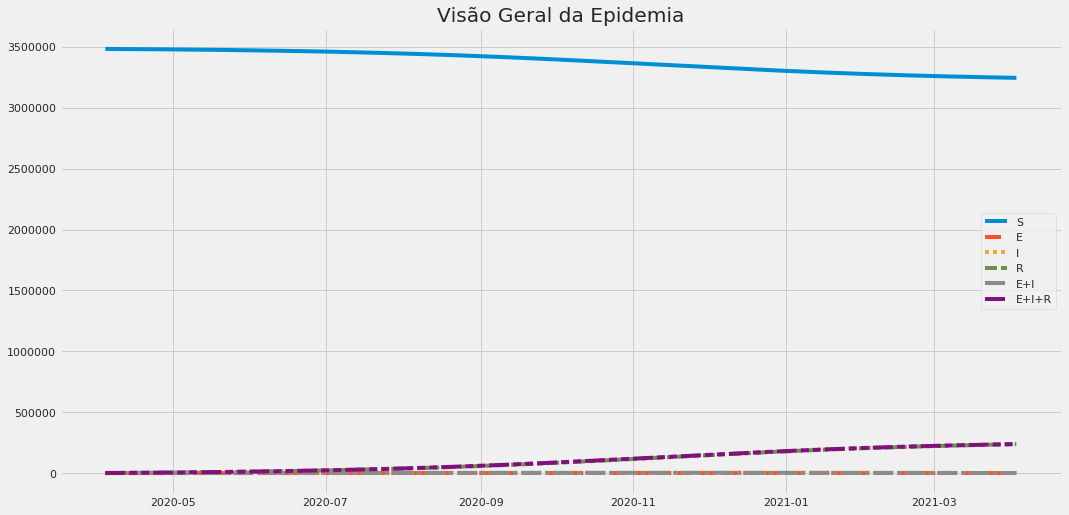

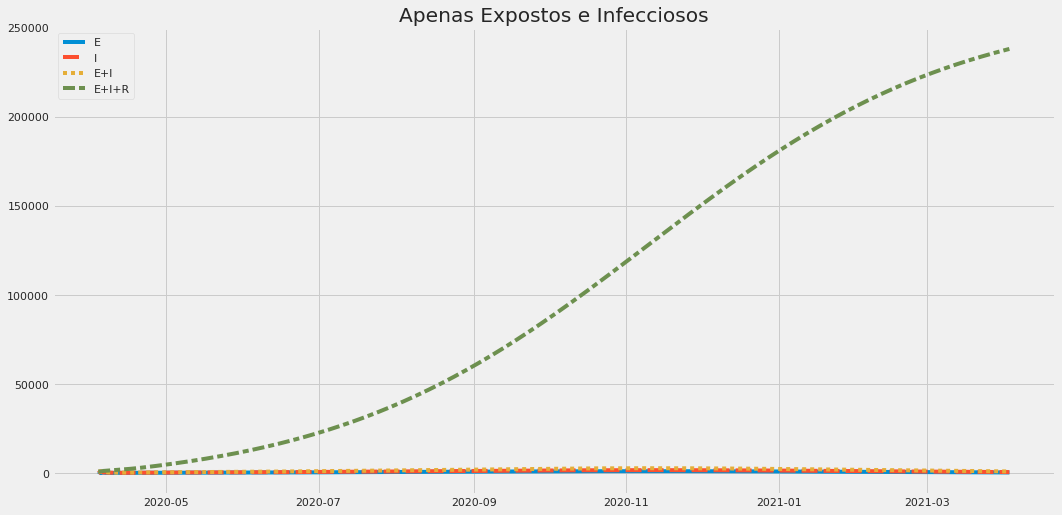

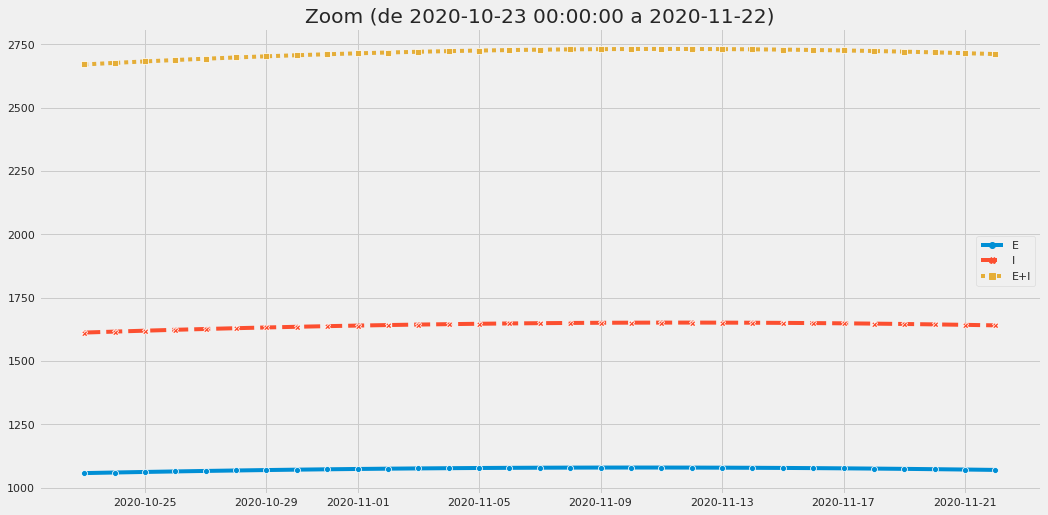

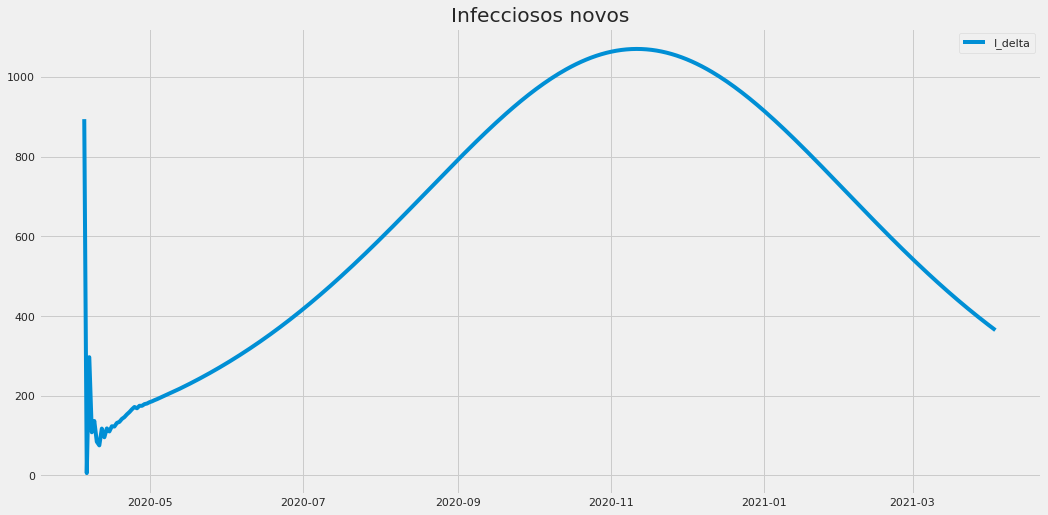

<Figure size 1152x576 with 0 Axes>

In [55]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_length=30, file_name='dynamic')

In [56]:
best['beta_3'] / best['gamma_1']

1.038467293342321

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

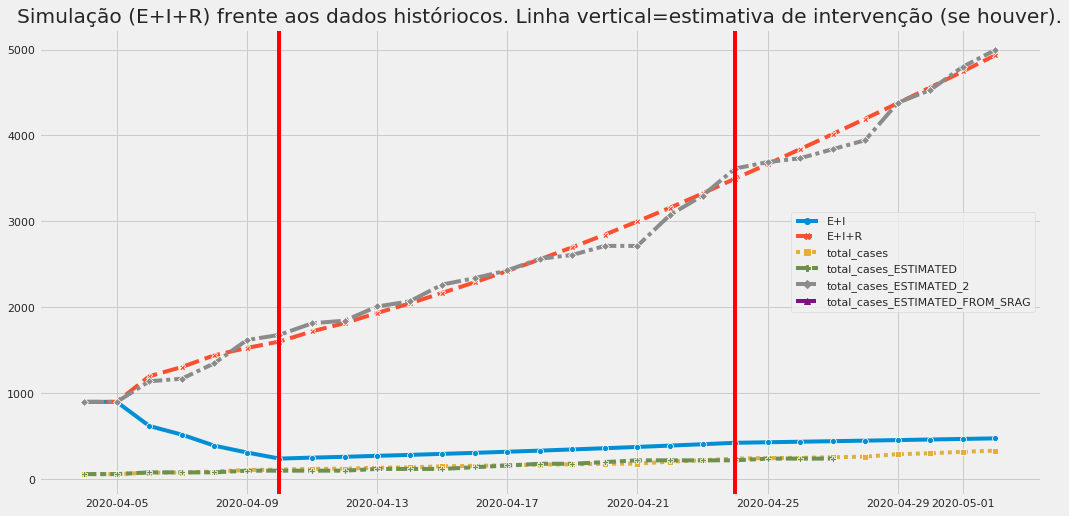

In [57]:
plot_curve_fitting(df_simulation_data=df_simulation_mitigation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   best=best, 
                   file_name='seir_dynamic_fit_zoom')

Finalmente, comparemos os casos com e sem mitigação.

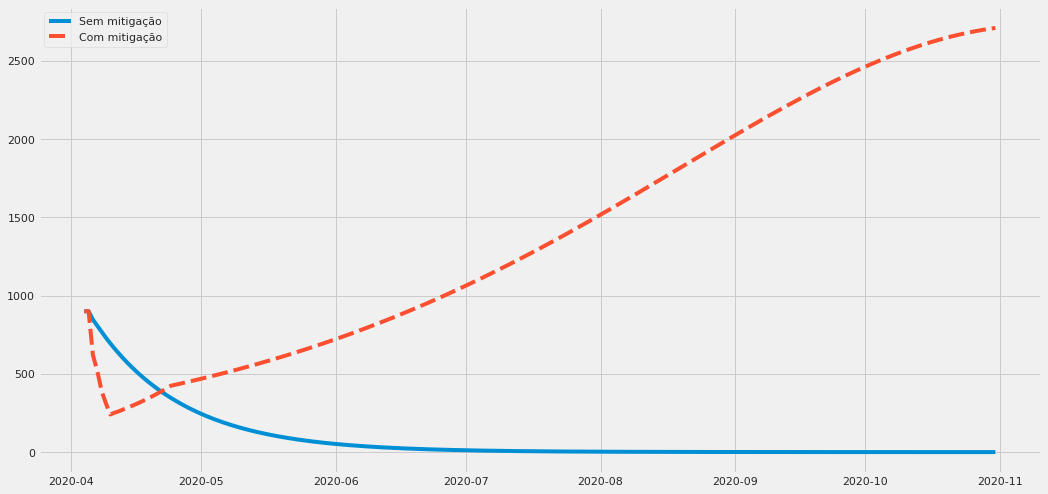

In [58]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com mitigação')], axis=1)['2020-03':'2020-10'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [59]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')

## Estudo de Calibragem de Parâmetros Variando-se Pontos de Corte Históricos 

Podemos também considerar o que ocorre com o treino do modelo conforme adquirimos mais dados históricos, simulando o ajuste do modelo ao longo de algumas janelas de tempo.

In [60]:
len(df_data_target)

31

In [61]:
%%time
if run_sensitivity_analysis:
    ss = []
    r0s = []
    for t in range(7, len(df_data_target), 1):
        print(f'###### t={t} ######')
        #space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, t)}

        t_2 = 10 if t >= 15.0 else 0.1
        t_3 = 10 if t >= 20.0 else 0.1

        ## assuming different gammas
        #
        #space = \
        #    {'dynamic':\
        #        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
        #           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
        #         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
        #        0, t)
        #    }

        # assuming gamma_1 == gamma_2 == gamma_3
        space = \
            {'dynamic':\
                ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
                   'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
                   'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
                   {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
                 {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
                0, t)
            }

        trials = hyperopt.Trials()
        best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

        print("Best parameters found:", best)

        alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                                    (best['alpha_2'], best['duration_2']),
                                    (best['alpha_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
        beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                                    (best['beta_2'], best['duration_2']),
                                    (best['beta_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
       #gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
       #                            (best['gamma_2'], best['duration_2']),
       #                            (best['gamma_3'], best['duration_3'])],
       #                            min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                                    (best['gamma_1'], best['duration_2']),
                                    (best['gamma_1'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)

        r0_1 = best['beta_1'] / best['gamma_1']
        r0_2 = best['beta_2'] / best['gamma_1'] # / best['gamma_2']
        r0_3 = best['beta_3'] / best['gamma_1'] # / best['gamma_3']

        r0s.append((r0_1, r0_2, r0_3))
        print(f'R0_1={r0_1}, R0_2={r0_2}, R0_3={r0_3}')


        df_simulation_partial_data = simulate(S=population_size - initially_infected, 
                                                  E=initially_infected,
                                                  I=0,
                                                  R=0, 
                                                  alpha=alpha, beta=beta, gamma=gamma, 
                                                  epidemic_start_date=epidemic_start_date, 
                                                  epidemic_duration_in_days=epidemic_duration_in_days, 
                                                  s_func=s, 
                                                  e_func=e,
                                                  i_func=i, 
                                                  r_func=r,
                                                  e_delta_func=e_delta,
                                                  i_delta_func=i_delta,
                                                  r_delta_func=r_delta)

        ss.append(df_simulation_partial_data['E+I'].rename(f'E+I, t <= {t}'))
        #ax = sns.lineplot(data=df_simulation_partial_data['E+I']['2020-03':'2020-07'])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs


In [62]:
if run_sensitivity_analysis:
    df_r0 = pd.DataFrame(r0s)
    df_r0 = df_r0[df_r0 < 25]#.rolling(3).mean()
    ax = sns.lineplot(data=df_r0, dashes=False)

In [63]:
if run_sensitivity_analysis:
    df = pd.concat(ss, axis=1)['2020-03':'2020-09']

In [64]:
if run_sensitivity_analysis:
    df_filtered = df.iloc[:, 25:]
    palette = sns.color_palette("coolwarm", len(df_filtered.columns))
    ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [65]:
if run_sensitivity_analysis:
    palette = sns.color_palette("coolwarm", len(df.columns))
    ax = sns.lineplot(data=df, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [66]:
if run_sensitivity_analysis:
    ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_2' + f'_{target_location.lower()}' + results_suffix + '.png', 
                      format='png')

    df.head()

Vemos que há grande sensibilidade do modelo frente a pequenos ajustes nos parâmetros de entrada, embora a maior quantidade de dados favoreça maior estabilidade.